# **Analyse**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

**Data loading**

Data frame pour visualisation

In [4]:
df = pd.read_csv('./data/final_data.zip')

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/459618280.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/final_data.zip')


In [5]:
df.sample(5)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
199905,CERTFR-2024-AVI-0778,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-09-13T11:30:25.169458,CVE-2024-42109,NaN,NaN,Non disponible,0.00042,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"f22954f8c58fd5f5489f5980796914e306757e77, 4184...",False,1326.0
187351,CERTFR-2025-AVI-0184,Multiples vulnérabilités dans le noyau Linux d...,Avis,2025-03-07T00:00:00.000000,CVE-2024-53128,NaN,NaN,Non disponible,0.00058,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"1da177e4c3f41524e886b7f1b8a0c1fc7321cac2, 1da1...",False,2167.0
52135,CERTFR-2024-AVI-0478,Multiples vulnérabilités dans les produits Sie...,Avis,2024-06-11T00:00:00.000000,CVE-2023-44317,7.2,Élevée,CWE-349,0.00153,https://www.cert.ssi.gouv.fr/openapi.json,A vulnerability has been identified in RUGGEDC...,Siemens,SCALANCE M876-3,0,False,2901.0
157213,CERTFR-2024-AVI-0205,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-03-13T01:00:00.000000,CVE-2024-21444,8.8,Élevée,CWE-190,0.00053,https://www.cert.ssi.gouv.fr/openapi.json,Microsoft WDAC OLE DB provider for SQL Server ...,Microsoft,Windows Server 2012,6.2.9200.0,False,81.0
167319,CERTFR-2025-AVI-0252,Multiples vulnérabilités dans le noyau Linux d...,Avis,2025-03-28T00:00:00.000000,CVE-2022-49523,NaN,NaN,Non disponible,0.00021,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"5.6, 0, 5.10.121, 5.15.46, 5.17.14, 5.18.3, 5.19",False,2800.0


In [6]:
df.shape

(225314, 16)

In [7]:
df_avant_clean = df.copy()

# Data cleaning

Conversion des types

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
df["CVSS"] = pd.to_numeric(df["CVSS"], errors="coerce")
df["EPSS"] = pd.to_numeric(df["EPSS"], errors="coerce")

CVSS cleaning

In [9]:
# si moins de 10% sont vides -> supprimer, sinon -> remplir
cvss_nan_pct = df["CVSS"].isna().mean()
if cvss_nan_pct < 0.1:
    df = df.dropna(subset=["CVSS"])
else: 
    df["CVSS"] = df["CVSS"].fillna(df["CVSS"].median())
    print("Choix : remplacer par la valeur médiane") #median pour éviter les outliers

Choix : remplacer par la valeur médiane


EPSS cleaning

In [10]:
epss_nan_pct = df["EPSS"].isna().mean()
if epss_nan_pct < 0.1:
    df = df.dropna(subset=["EPSS"])
else:
    df["EPSS"] = df["EPSS"].fillna(df["EPSS"].median())
    print("Choix : remplacer par la valeur médiane")

In [11]:
df.shape

(224411, 16)

In [12]:
df = df[df["CWE"] != "Non disponible"]

In [13]:
df.shape

(118702, 16)

Base severity

In [14]:
def gravite_from_cvss(cvss):
    if pd.isna(cvss):
        return "Non spécifié"
    if cvss >= 9.0:
        return "Critique"
    elif cvss >= 7.0:
        return "Élevée"
    elif cvss >= 4.0:
        return "Moyenne"
    else:
        return "Faible"

df["Base Severity"] = df["CVSS"].apply(gravite_from_cvss)

Supprimer lignes avec valeurs manquantes pour l'éditeur ou le produit

In [15]:
df = df[df["Éditeur"].notna() & (df["Éditeur"] != "Non précisé")]
df = df[df["Produit"].notna()]

In [16]:
df.shape

(110770, 16)

In [17]:
df.sample(8)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
50208,CERTFR-2024-AVI-0854,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-10-09 00:00:00.000000,CVE-2024-43544,7.5,Élevée,CWE-400,0.10527,https://www.cert.ssi.gouv.fr/openapi.json,Microsoft Simple Certificate Enrollment Protoc...,Microsoft,Windows Server 2012 (Server Core installation),6.2.9200.0,False,80.0
112809,CERTFR-2024-AVI-0557,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-07-10 07:40:03.419387,CVE-2024-38078,7.5,Élevée,CWE-416,0.00090,https://www.cert.ssi.gouv.fr/openapi.json,Xbox Wireless Adapter Remote Code Execution Vu...,Microsoft,Windows 11 version 21H2,10.0.0,False,57.0
221610,CERTFR-2025-AVI-0039,Multiples vulnérabilités dans Microsoft Windows,Avis,2025-01-15 00:00:00.000000,CVE-2025-21234,7.8,Élevée,CWE-20,0.00273,https://www.cert.ssi.gouv.fr/openapi.json,Windows PrintWorkflowUserSvc Elevation of Priv...,Microsoft,Windows 10 Version 21H2,10.0.19043.0,False,65.0
402,CERTFR-2023-AVI-0022,Multiples vulnérabilités dans Microsoft Windows,Avis,2023-01-11 00:00:00.000000,CVE-2023-21747,7.8,Élevée,CWE-416,0.00226,https://www.cert.ssi.gouv.fr/openapi.json,Windows Kernel Elevation of Privilege Vulnerab...,Microsoft,Windows Server 2012,6.2.9200.0,False,51.0
114657,CERTFR-2023-AVI-0957,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-11-17 01:00:00.000000,CVE-2023-0458,5.3,Moyenne,CWE-476,0.00045,https://www.cert.ssi.gouv.fr/openapi.json,A speculative pointer dereference problem exis...,Linux,Linux Kernel,0,False,329.0
133483,CERTFR-2025-AVI-0499,Multiples vulnérabilités dans Microsoft Windows,Avis,2025-06-11 00:00:00.000000,CVE-2025-33059,5.5,Moyenne,CWE-125,0.00039,https://www.cert.ssi.gouv.fr/openapi.json,Out-of-bounds read in Windows Storage Manageme...,Microsoft,Windows Server 2016 (Server Core installation),10.0.14393.0,False,120.0
86489,CERTFR-2023-AVI-0754,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-09-15 00:00:00.000000,CVE-2023-3772,5.5,Moyenne,CWE-476,0.00010,https://www.cert.ssi.gouv.fr/openapi.json,A flaw was found in the Linux kernel’s IP fram...,Red Hat,Red Hat Enterprise Linux 6,NaN,False,287.0
94643,CERTFR-2024-AVI-0759,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-09-11 00:00:00.000000,CVE-2024-38014,7.8,Élevée,CWE-269,0.10523,https://www.cert.ssi.gouv.fr/openapi.json,Windows Installer Elevation of Privilege Vulne...,Microsoft,Windows 11 version 22H3,10.0.22631.0,False,54.0


Data frame pour modèles machine learning

In [18]:
df_IA = df.copy()

# **Visualisation**

**Severity level categorization function**

In [19]:
def cvss_to_severity(score):
    try:
        score = float(score)
        if score <= 3:
            return 'Faible'
        elif score <= 6:
            return 'Moyenne'
        elif score <= 8:
            return 'Élevée'
        else:
            return 'Critique'
    except:
        return 'Inconnu'

## 1. Histogram of severity levels (based on CVSS)

Avant cleaning

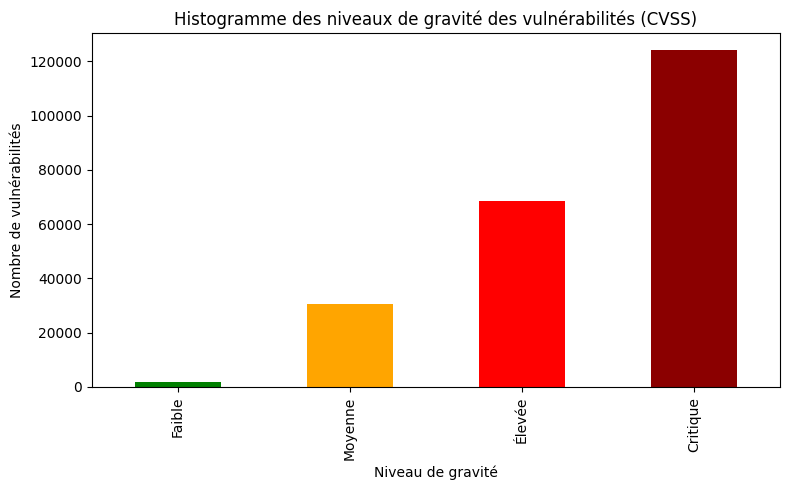

In [20]:
df_avant_clean['Gravité'] = df_avant_clean['CVSS'].apply(cvss_to_severity)
grav_counts = df_avant_clean['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.show()

_Dans l'histogramme avant nettoyage, on observe une forte dominance de la classe "Critique", qui dépasse nettement les 120 000 occurrences. La classe "Élevée" suit, avec environ 70 000 cas, tandis que les classes "Moyenne" et surtout "Faible" sont très sous-représentées (moins de 5 000 cas pour "Faible")._

Après clean

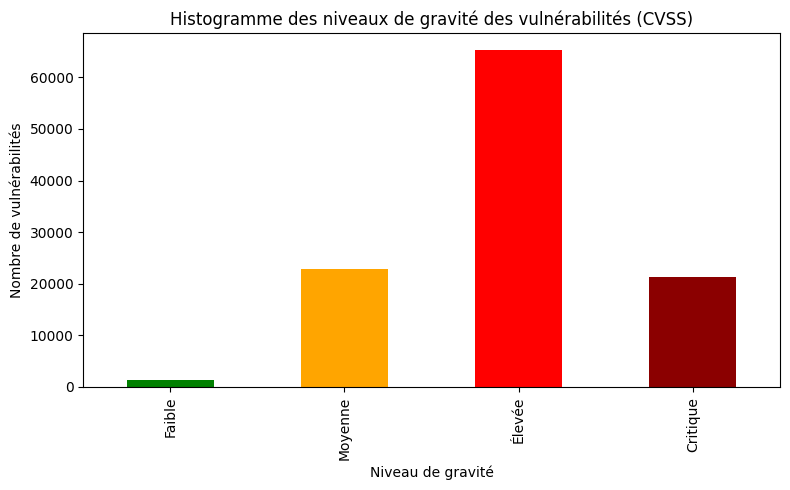

In [21]:
df['Gravité'] = df['CVSS'].apply(cvss_to_severity)
grav_counts = df['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.show()

_Dans le graphique après nettoyage, la classe "Critique" chute à environ 21 000 vulnérabilités, tandis que la classe "Élevée" devient majoritaire avec environ 65 000 cas. La classe "Moyenne" reste relativement stable, et "Faible" toujours marginale._

_Ce changement significatif s’explique par notre stratégie de remplissage des valeurs manquantes de CVSS par la médiane. Si cette médiane correspond à un score de gravité élevé mais non critique (entre 6.0 et 8.9), alors les vulnérabilités précédemment non classées ont été affectées à la classe "Élevée", ce qui réduit artificiellement la part des "Critique" et augmente mécaniquement celle des "Élevée"._

## 2. Circular vulnerability diagram (CWE)

Top 10 CWE les plus fréquents, les autres groupés par "Others"

In [22]:
top_cwe = df['CWE'].value_counts()
top_18 = top_cwe.head(18)
autres = top_cwe[18:].sum()
top_18['Autres'] = autres

Plot

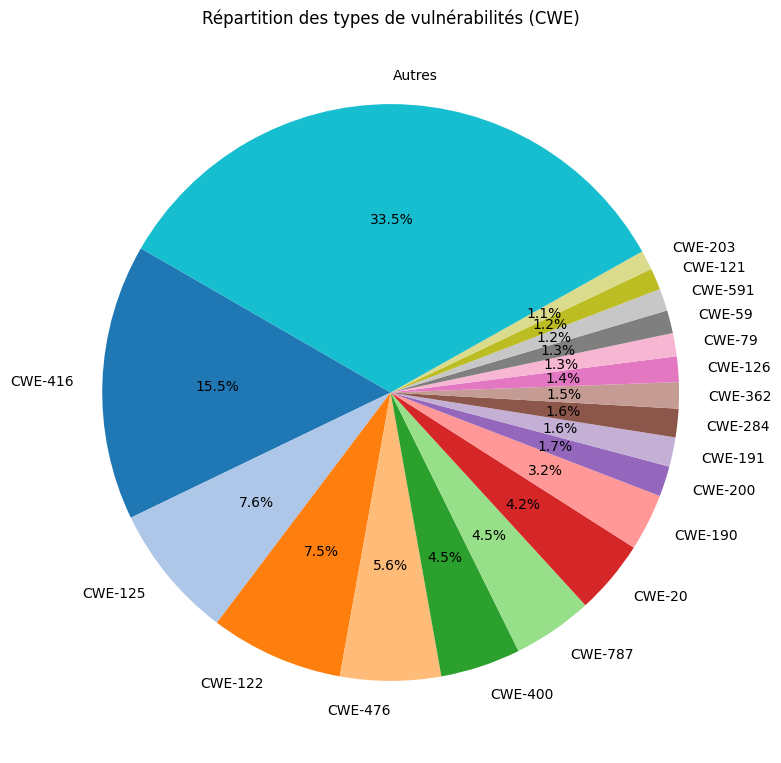

In [23]:
plt.figure(figsize=(8,8))
colors = plt.cm.tab20.colors[:len(top_18)]
top_18.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=colors)
plt.title('Répartition des types de vulnérabilités (CWE)')
plt.ylabel('')
plt.tight_layout()
plt.show()

_Le diagramme montre que les vulnérabilités sont très diverses, avec un tiers (33,5 %) regroupées sous la catégorie "Autres", ce qui indique une large variété de failles peu fréquentes individuellement. Parmi les types spécifiques, la faille la plus fréquente est CWE-416 (Use After Free, 15,5 %), une erreur critique liée à l’utilisation de la mémoire après libération, souvent exploitée pour exécuter du code malveillant. Elle est suivie par CWE-125 (Out-of-bounds Read, 7,6 %), une lecture hors des limites de la mémoire, qui peut entraîner la fuite d’informations sensibles._

_Les dépassements de tampon sont aussi très représentés avec CWE-122 (Heap-based Buffer Overflow, 7,5 %) et CWE-787 (Out-of-bounds Write, 4,5 %), tous deux pouvant permettre une prise de contrôle du système. CWE-476 (NULL Pointer Dereference, 5,6 %) cause souvent des plantages d’application, tandis que CWE-400 (Uncontrolled Resource Consumption, 4,5 %) désigne des attaques par saturation des ressources comme le DoS. CWE-20 (Improper Input Validation, 4,2 %) montre que de nombreux systèmes ne filtrent pas correctement les données d’entrée, ce qui les rend vulnérables à diverses injections._

_Parmi les failles moins fréquentes mais notables, on trouve CWE-200 (Information Exposure, 3,2 %), CWE-190 (Integer Overflow, 1,7 %), CWE-79 (Cross-site Scripting), CWE-284 (Improper Access Control), et CWE-362 (Race Condition), toutes potentiellement critiques selon leur contexte d’exploitation. Globalement, on remarque que beaucoup de ces vulnérabilités viennent de mauvaises pratiques de programmation, notamment dans la gestion de la mémoire ou dans le manque de vérification des données, surtout dans des langages comme C ou C++._

## 3. EPSS Score Density Curve

In [24]:
epss = df['EPSS']

Plot

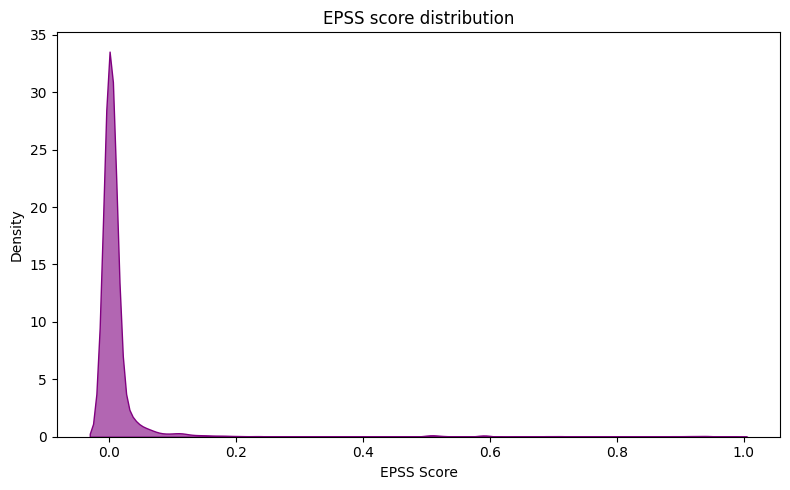

In [25]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Zoom sur les petits EPSS Score

In [26]:
epss_filtered = epss[(epss >= 0) & (epss <= 0.10)]

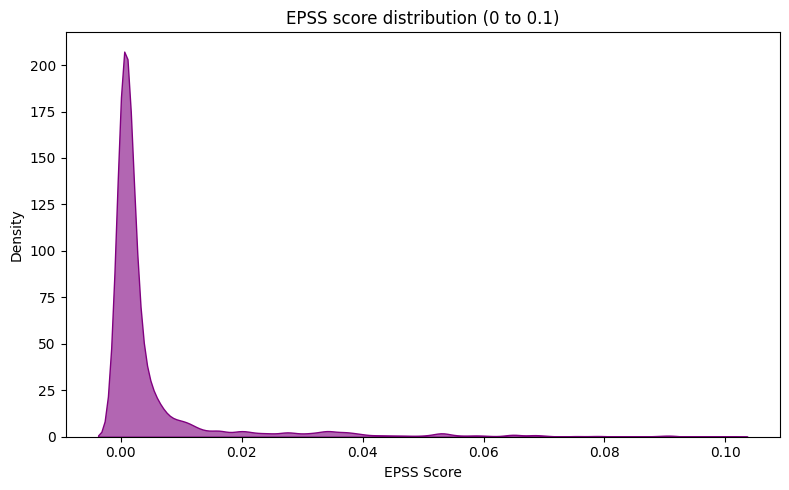

In [27]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss_filtered, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution (0 to 0.1)')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## 4. Top Affected editors

Top 10 editeurs les plus fréquents

In [28]:
top_editors = df['Éditeur'].value_counts().head(10)

Plot

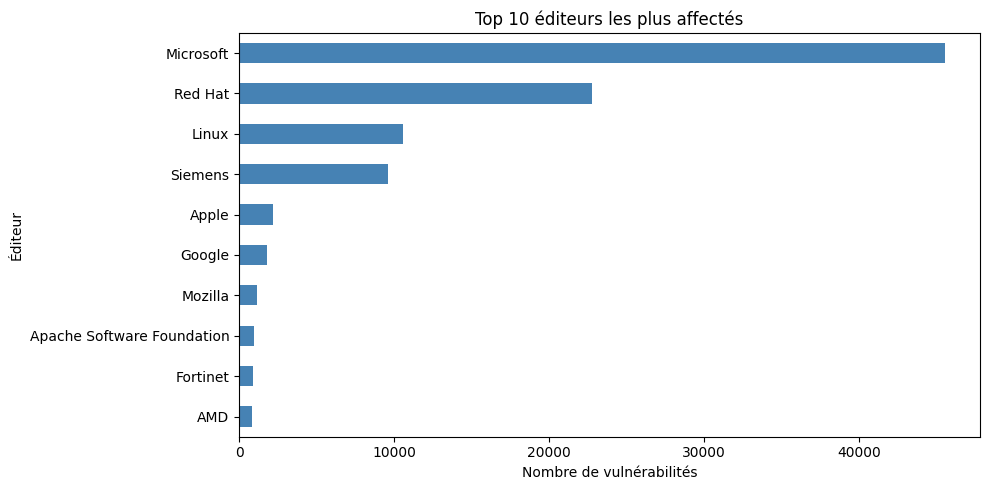

In [29]:
plt.figure(figsize=(10, 5))
top_editors.plot(kind='barh', color='steelblue')
plt.title('Top 10 éditeurs les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

_Cette visualisation montre les 10 éditeurs les plus touchés par des vulnérabilités. Microsoft domine largement avec plus de 45 000 vulnérabilités, suivi par Red Hat (environ 23 000) et Linux (un peu plus de 11 000). Les autres éditeurs comme Siemens, Apple, Google ou Mozilla présentent des volumes bien moindres. Cela reflète des différences en termes de surface d’attaque, de types de produits ou de politiques de gestion des vulnérabilités._

_Pour l’analyse en machine learning, ces données peuvent orienter le choix des variables. Dans un modèle non supervisé comme K-Means, le nombre de vulnérabilités par éditeur, leur criticité ou leur nature peuvent permettre d’identifier des groupes cohérents (ex. : industriels vs systèmes d’exploitation). Une normalisation sera sans doute nécessaire, car certains éditeurs sont fortement surreprésentés. Dans un modèle supervisé comme Random Forest, ces mêmes variables peuvent servir à prédire le niveau de gravité ou de risque d’une alerte. Il faudra cependant veiller à l’équilibre des classes, car certains éditeurs dominants pourraient biaiser l’apprentissage._

## 5. Top affected products

Top 10 produits les plus fréquents

In [30]:
top_products = df['Produit'].value_counts().head(10)

Plot

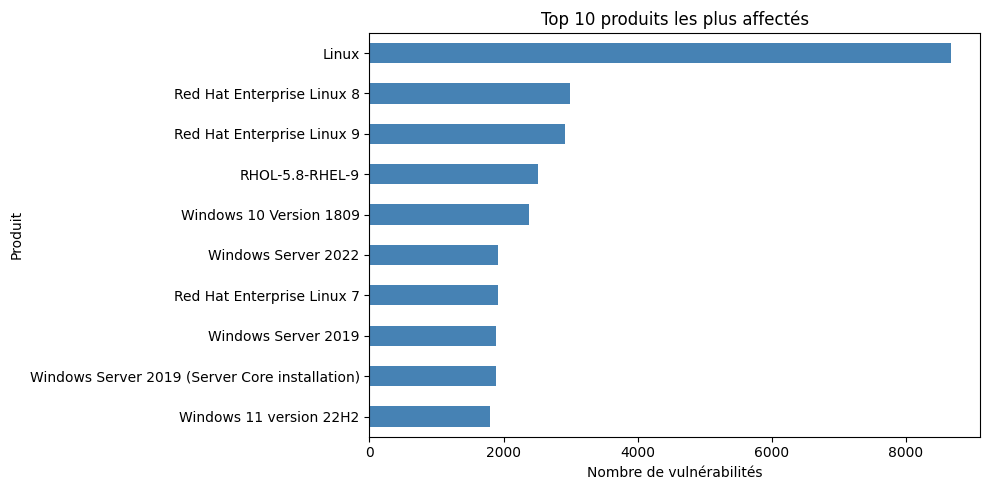

In [31]:
plt.figure(figsize=(10, 5))
top_products.plot(kind='barh', color='steelblue')
plt.title('Top 10 produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

_Ce graphique présente les 10 produits les plus touchés par des vulnérabilités selon les données issues des alertes ANSSI enrichies par les CVE. Le système Linux arrive largement en tête avec plus de 8 000 vulnérabilités, ce qui montre son exposition importante, probablement liée à sa large utilisation et à sa nature open source. On retrouve ensuite plusieurs versions de Red Hat Enterprise Linux (versions 8, 9 et 7) et de Windows (Windows 10, 11, Server 2019, Server 2022), ce qui reflète la concentration des vulnérabilités dans les systèmes d’exploitation largement déployés dans les environnements professionnels._

## 6. Heatmap : Correlation between CVSS and EPSS

Créer un dataframe correlation

In [32]:
correlation_df = df[["CVSS", "EPSS"]]

In [33]:
df["Gravité_CVSS"] = df["CVSS"].apply(cvss_to_severity)

Categoriser EPSS en 4 niveaux

In [34]:
def epss_to_level(epss):
    if epss <= 0.25:
        return "Faible"
    elif epss <= 0.5:
        return "Moyenne"
    elif epss <= 0.75:
        return "Élevée"
    else:
        return "Critique"

In [35]:
df["Probabilité_EPSS"] = df["EPSS"].apply(epss_to_level)

Création de la heatmap

In [36]:
heatmap_data = pd.crosstab(df["Gravité_CVSS"], df["Probabilité_EPSS"])
heatmap_data = heatmap_data.reindex(index=["Critique", "Élevée", "Moyenne", "Faible"],
                                     columns=["Faible", "Moyenne", "Élevée", "Critique"])

Plot

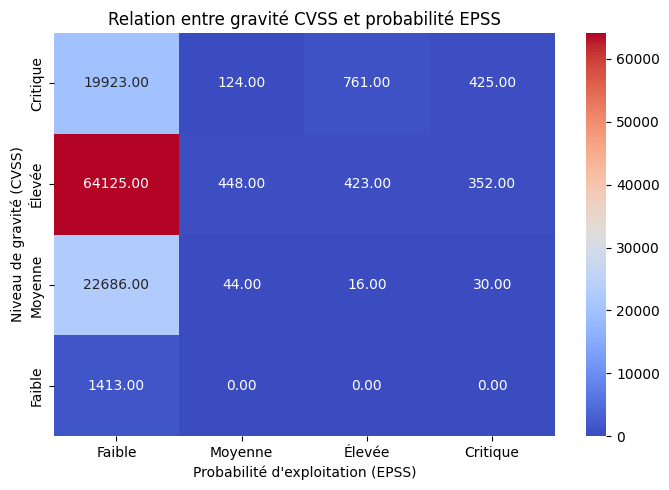

In [37]:
plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Relation entre gravité CVSS et probabilité EPSS")
plt.xlabel("Probabilité d'exploitation (EPSS)")
plt.ylabel("Niveau de gravité (CVSS)")
plt.tight_layout()
plt.show()

## 7. Scatter plot : CVSS vs EPSS

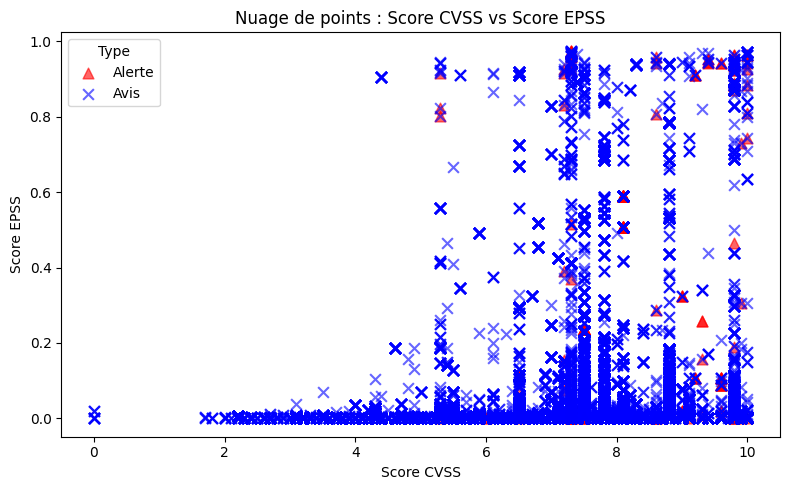

In [38]:
plt.figure(figsize=(8, 5))

# Couleurs et marqueurs pour chaque type
color_map = {'Alerte': 'red', 'Avis': 'blue'}
marker_map = {'Alerte': '^', 'Avis': 'x'}

for t in ['Alerte', 'Avis']:
    subset = df[df['Type'] == t]
    plt.scatter(subset['CVSS'], subset['EPSS'],
                color=color_map[t],
                marker=marker_map[t],
                alpha=0.6,
                s=60,
                label=t)

plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.legend(title="Type")
plt.tight_layout()
plt.show()


## 8. Courbe cumulative : Vulnérabilités dans le temps

In [39]:
df_sorted = df.sort_values("Date")

Regroupement par date et calcul de la somme cumulée

In [40]:
cumulative_df = df_sorted.groupby("Date").size().cumsum()

Plot

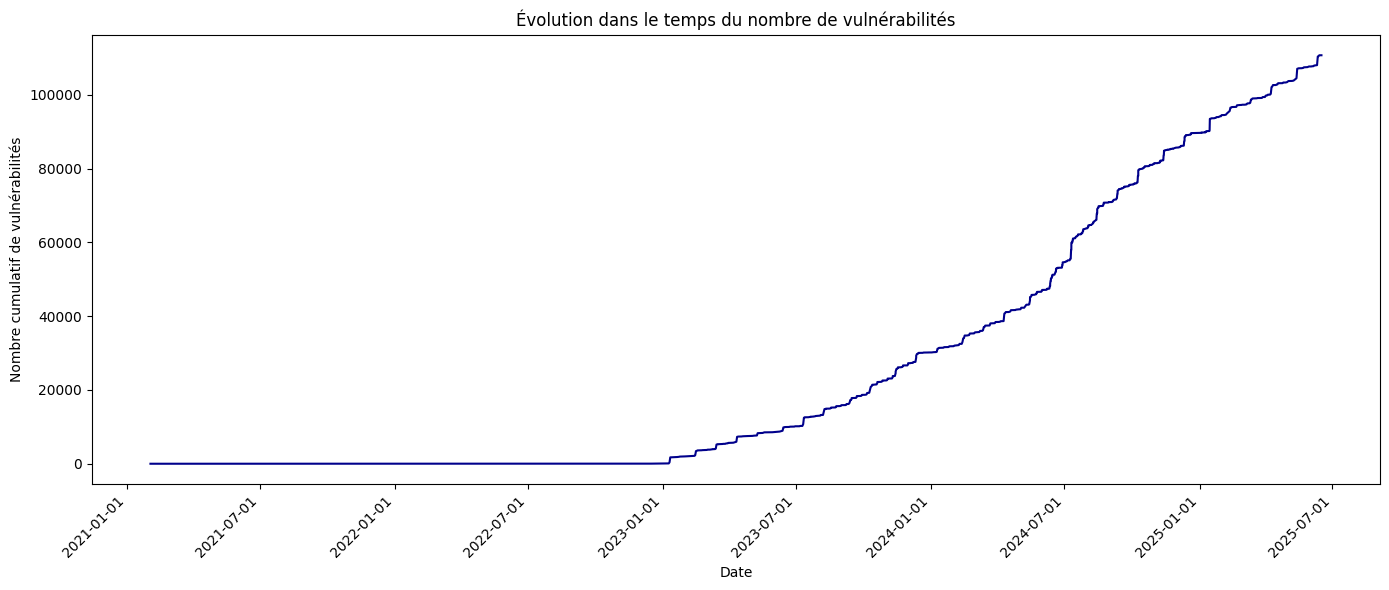

In [41]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cumulative_df.index, cumulative_df.values, color="darkblue")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.title("Évolution dans le temps du nombre de vulnérabilités")
plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.tight_layout()
plt.show()

_Ce graphique montre l’évolution cumulative du nombre de vulnérabilités détectées dans le temps. On observe une forte augmentation à partir du début de l’année 2023, avec une croissance rapide et continue jusqu’à mi-2025. Cette tendance s'explique en partie par la structure de notre jeu de données, puisque la majorité des CVE ont été collectées à partir de 2023. Cela explique la quasi-absence de vulnérabilités avant cette date, qui résulte davantage d’un manque de données que d’une réelle stabilité._

_Cependant, malgré ce biais lié à la collecte, on constate tout de même une tendance de fond à la hausse, ce qui souligne l'augmentation continue des failles de sécurité au fil du temps. Cela met en évidence l'importance croissante des enjeux liés à la sécurité réseau et à la cybersécurité._

## 9. Boxplot : scores CVSS par top éditeurs

Filtre

In [42]:
top_editors = df['Éditeur'].value_counts().head(10).index
boxplot_df = df[df['Éditeur'].isin(top_editors)]

Plot

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/3526360994.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')


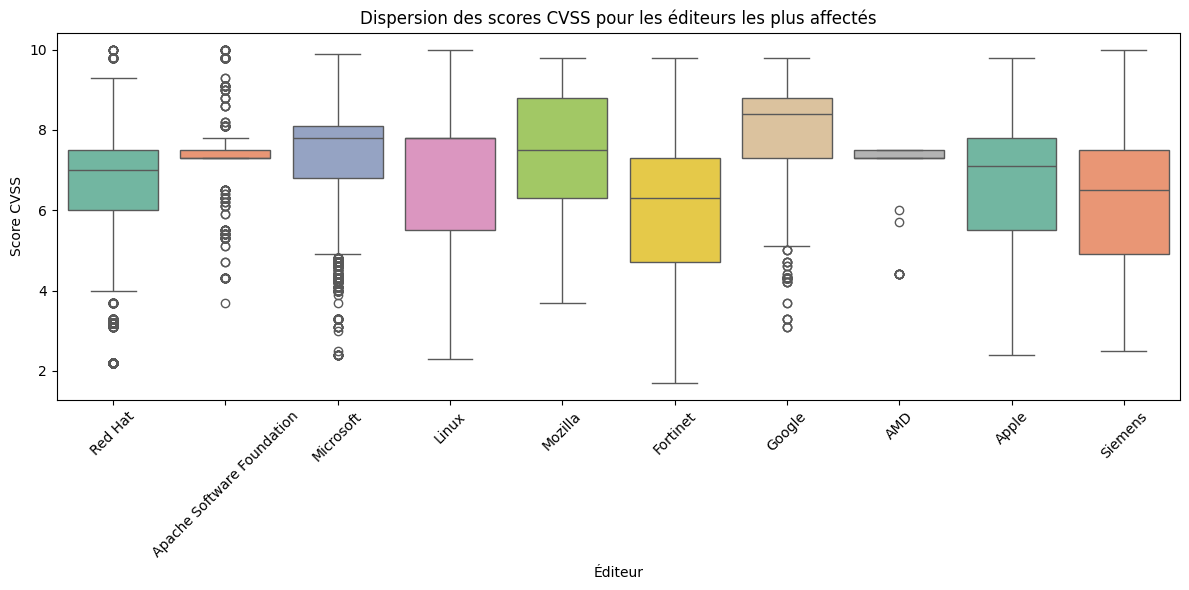

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')
plt.title('Dispersion des scores CVSS pour les éditeurs les plus affectés')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Évolution temporelle des vulnérabilités CWE-416 (« Use After Free » : utilisation après libération de la mémoire)

In [44]:
cwe_416_df = df[df["CWE"] == "CWE-416"]

Grouper par mois

In [45]:
cwe_416_monthly = cwe_416_df.groupby(df["Date"].dt.to_period("M")).size()
cwe_416_monthly.index = cwe_416_monthly.index.to_timestamp()

Plot

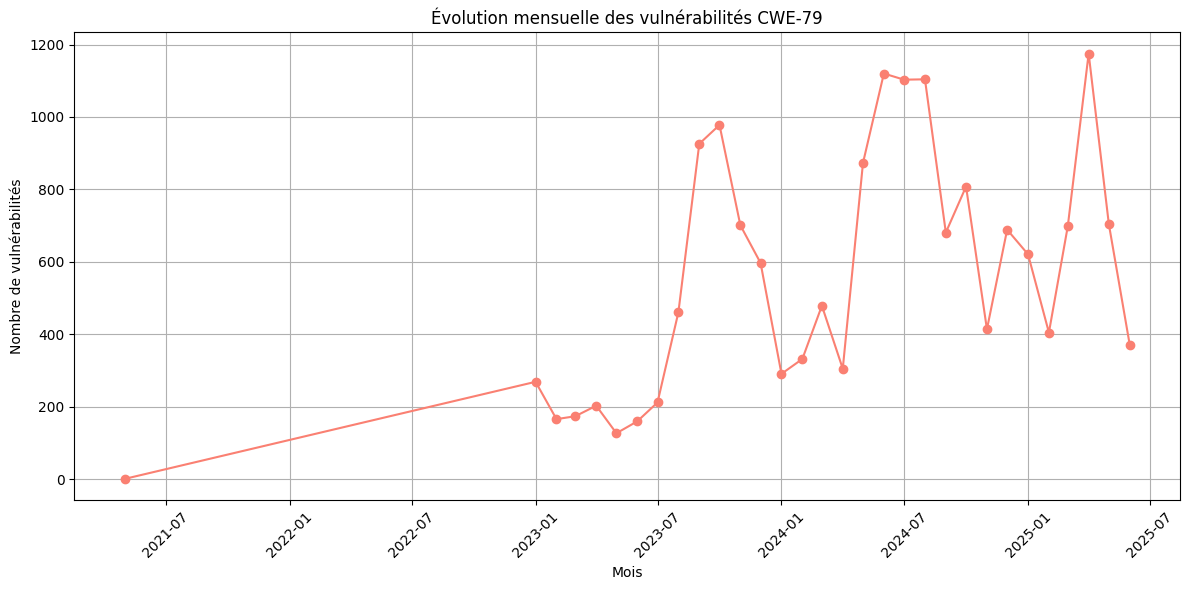

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(cwe_416_monthly.index, cwe_416_monthly.values, marker="o", linestyle="-", color="salmon")
plt.title("Évolution mensuelle des vulnérabilités CWE-79")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Histogramme des vulnérabilités par produit pour CWE-125 : Lecture hors limites

Selection du CWE-125

In [47]:
cwe_cible = "CWE-125"
df_cwe = df[df["CWE"] == cwe_cible]

Compter les vulnérabilités par produit

In [48]:
produit_counts = df_cwe["Produit"].value_counts().sort_values(ascending=False).head(15)

Plot

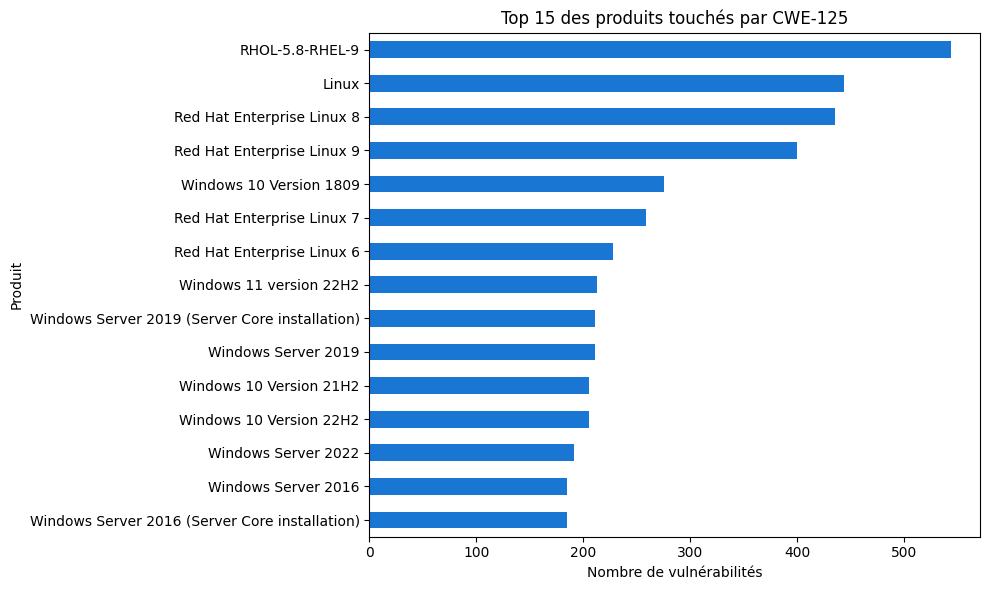

In [49]:
plt.figure(figsize=(10,6))
produit_counts.plot(kind="barh", color="#1976D2")
plt.gca().invert_yaxis()
plt.title(f"Top 15 des produits touchés par {cwe_cible}")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.tight_layout()
plt.show()

## 12. Heatmap CWE x editeur

Heatmap

In [50]:
heatmap_data = pd.crosstab(df["CWE"], df["Éditeur"])

Selection (sinon trop de valeurs)

In [51]:
top_cwe = heatmap_data.sum(axis=1).sort_values(ascending=False).head(15).index
top_editeurs = heatmap_data.sum(axis=0).sort_values(ascending=False).head(14).index
filtered_data = heatmap_data.loc[top_cwe, top_editeurs]

Plot

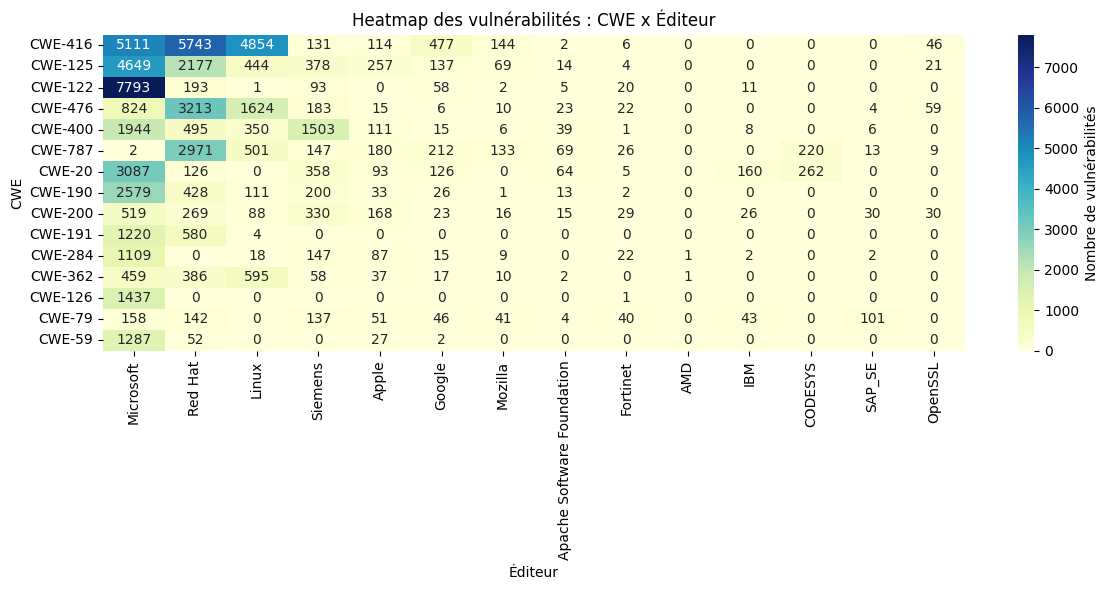

In [52]:
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Nombre de vulnérabilités'})
plt.title("Heatmap des vulnérabilités : CWE x Éditeur")
plt.xlabel("Éditeur")
plt.ylabel("CWE")
plt.tight_layout()
plt.show()

## 13. Tendances mensuelles de la vulnérabilité par CWE (courbes superposées)

Extraction du mois et de l'année

In [53]:
df["Mois"] = df["Date"].dt.to_period("M")  # Format AAAA-MM

Garder les 8 CWE les plus fréquents

In [54]:
top_cwes = df[df["CWE"] != "Non disponible"]["CWE"].value_counts().head(5).index
df_top = df[df["CWE"].isin(top_cwes)]

Garder seulement après janvier 2023

In [55]:
df_top = df_top[df_top["Mois"] >= "2023-01"]

Groupement : nombre de vulnérabilités par mois et par CWE

In [56]:
df_grouped = df_top.groupby(["Mois", "CWE"]).size().unstack(fill_value=0)

Plot

<Figure size 1200x600 with 0 Axes>

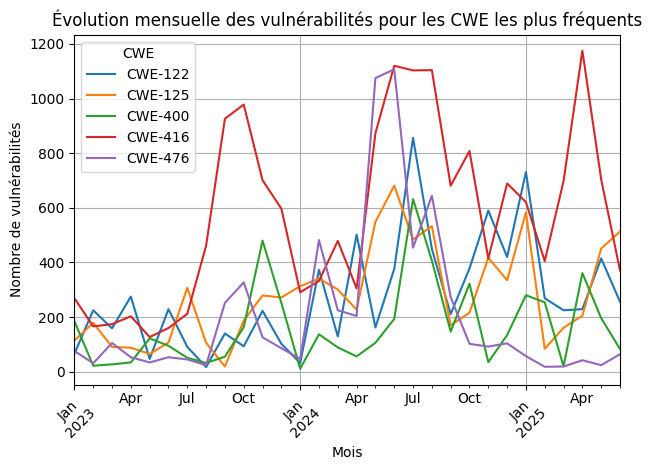

In [57]:
plt.figure(figsize=(12, 6))
df_grouped.plot()
plt.title("Évolution mensuelle des vulnérabilités pour les CWE les plus fréquents")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.legend(title="CWE")
plt.tight_layout()
plt.grid(True)
plt.show()

## 14. Heatmap : vunerabilités temporelles

In [58]:
df["Année"] = df["Date"].dt.year
df["Mois"] = df["Date"].dt.month

In [59]:
pivot = pd.crosstab(df["Année"], df["Mois"]).fillna(0)

Plot

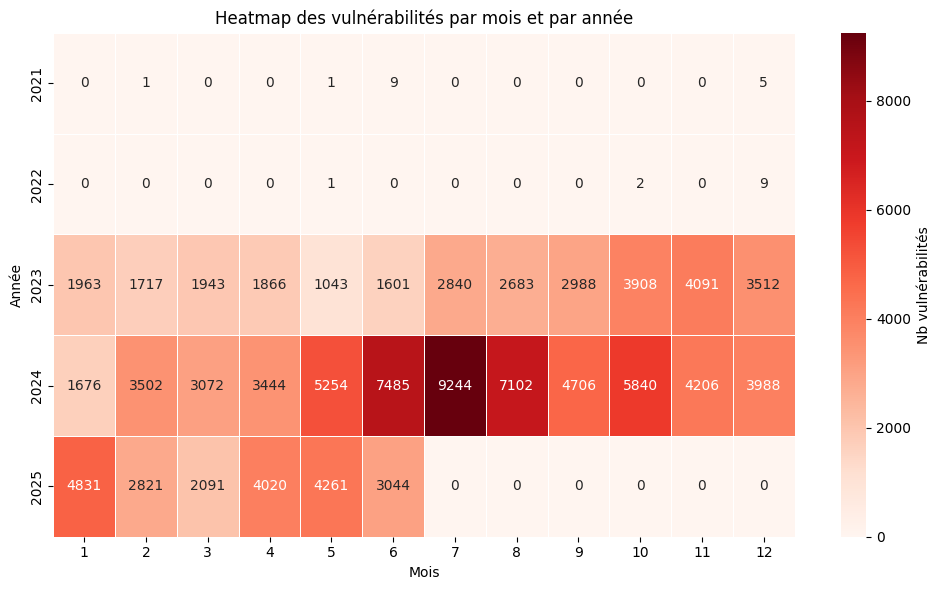

In [60]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Nb vulnérabilités'})
plt.title("Heatmap des vulnérabilités par mois et par année")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()

## 15. Scatter : produit & version

Définir produits et versions les plus fréquents

In [61]:
top_produits = df["Produit"].value_counts().head(25).index
top_versions = df["Versions affectées"].value_counts().head(15).index

In [62]:
df_top_both = df[
    (df["Produit"].isin(top_produits)) &
    (df["Versions affectées"].isin(top_versions))
]

df_top_both.loc[:, "Versions affectées"] = df_top_both["Versions affectées"].apply(
    lambda v: v if len(v) <= 20 else v[:17] + "..."
)

Plot

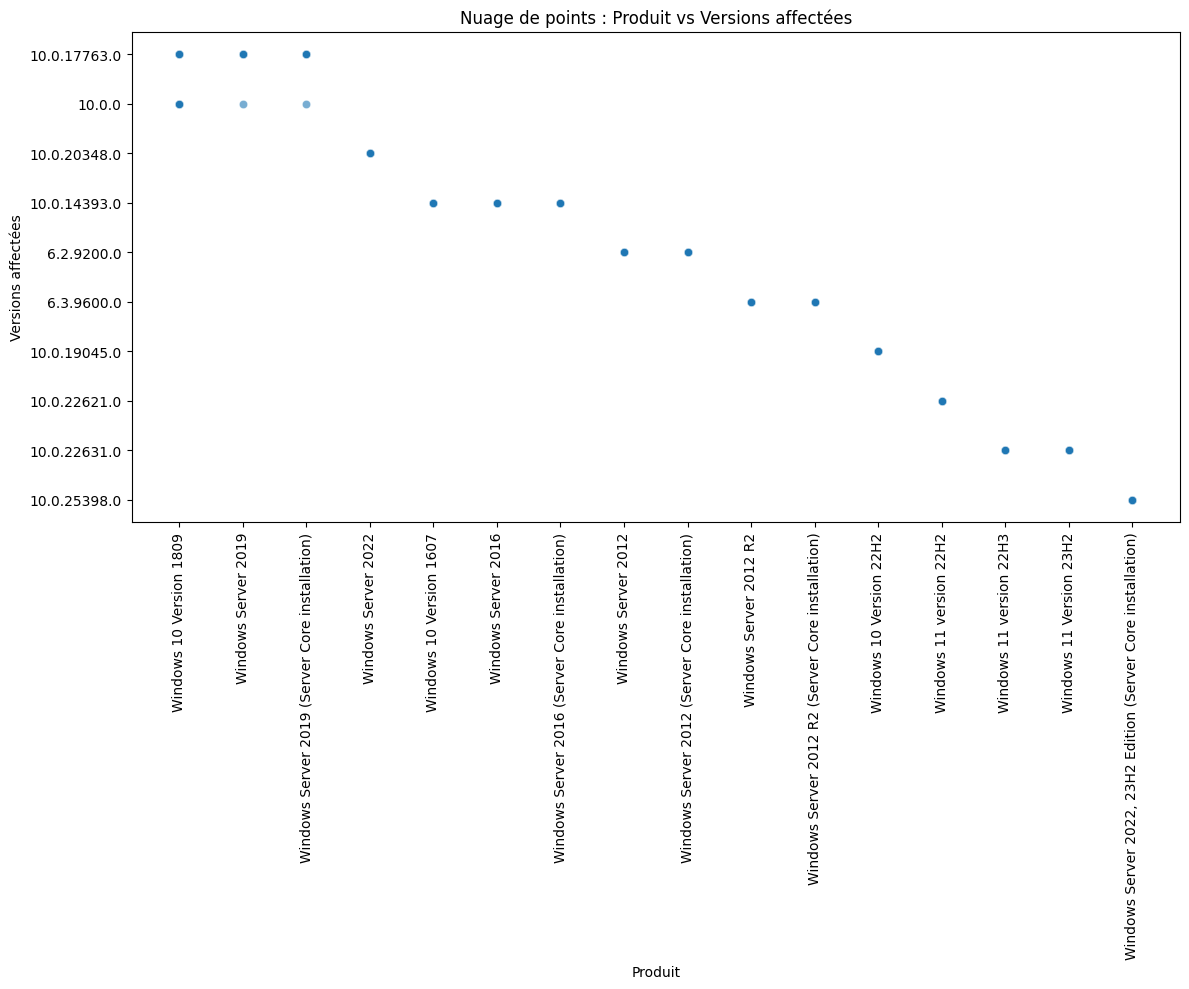

In [63]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_top_both, x="Produit", y="Versions affectées", alpha=0.6)

plt.xticks(rotation=90)
plt.title("Nuage de points : Produit vs Versions affectées")
plt.xlabel("Produit")
plt.ylabel("Versions affectées")
plt.tight_layout()
plt.show()

## 16. Bar chart : top 10 versions les plus impactées par les vulnerabilités

Filtrer

In [64]:
versions = df["Versions affectées"]
versions = versions[versions != "n/a"]

In [65]:
version_counts = versions.value_counts().head(10)

Plot

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/2037418214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")


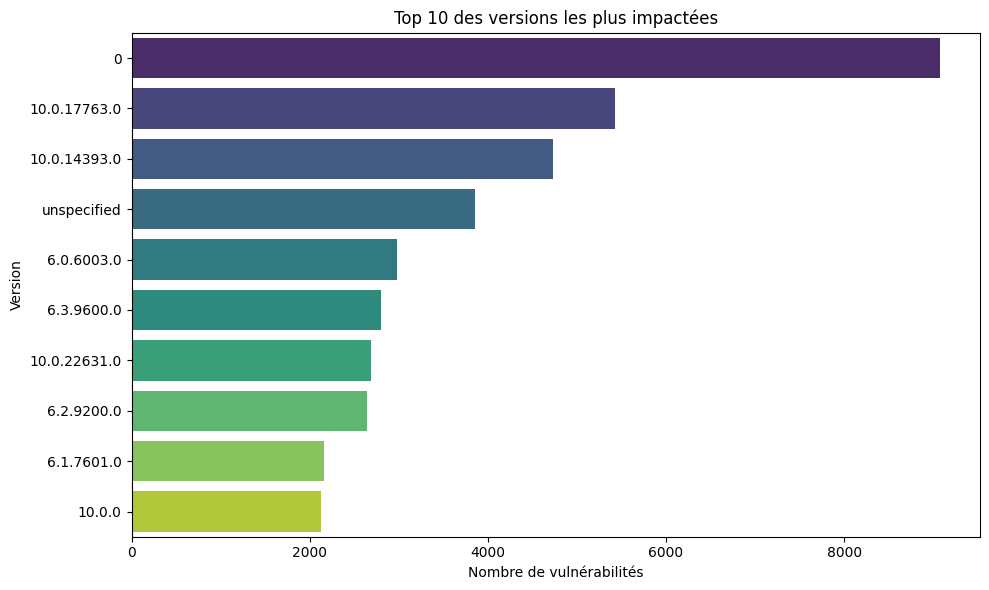

In [66]:
plt.figure(figsize=(10, 6))
sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")

plt.title("Top 10 des versions les plus impactées")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Version")
plt.tight_layout()
plt.show()

## 17. Evolution temporelle des vulnérabilités par type de bulletin (Avis/Alertes)

In [67]:
df['Type'] = df['Type'].str.strip() 
df = df[df['Type'].isin(['Avis', 'Alerte'])]

In [68]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Mois'] = df['Date'].dt.to_period('M').astype(str)

Groupe par mois et par type (avis/alerte)

In [69]:
df_evol = df.groupby(['Mois', 'Type']).size().reset_index(name='Nombre')

Tri par mois chronologique

In [70]:
df_evol['Mois'] = pd.to_datetime(df_evol['Mois'])
df_evol = df_evol.sort_values('Mois')

Plot

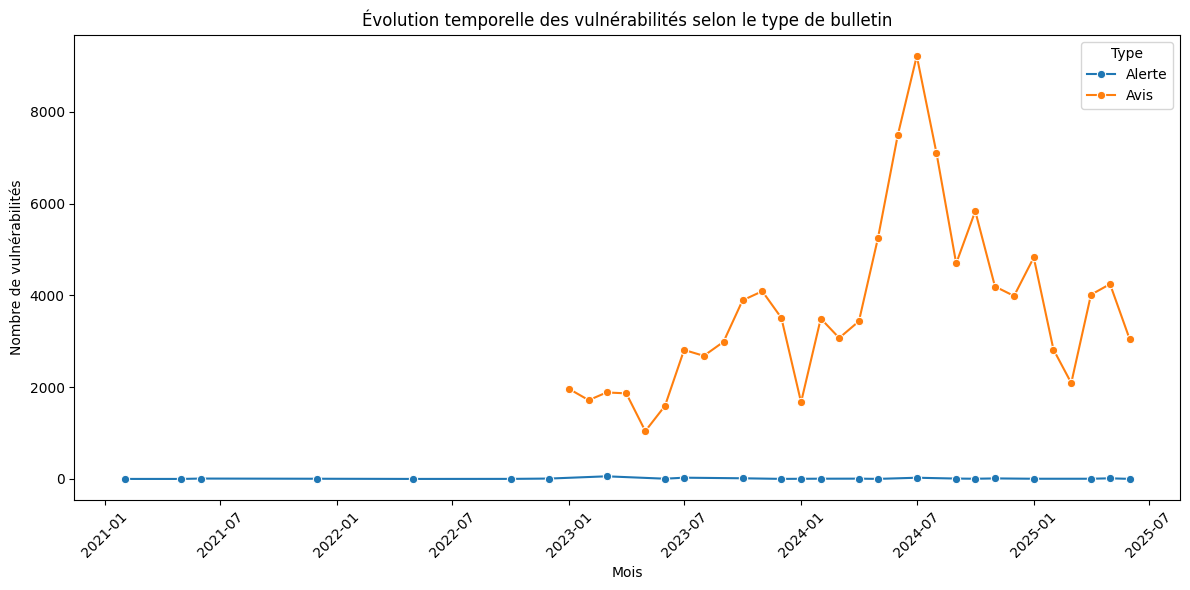

In [71]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_evol, x='Mois', y='Nombre', hue='Type', marker='o')
plt.title("Évolution temporelle des vulnérabilités selon le type de bulletin")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 18. Vulnerabilités par editeur et type (alerte/avis)

Grouper par editeur et type

In [72]:
df_bar = df.groupby(['Éditeur', 'Type']).size().unstack(fill_value=0)

Garder les 15 éditeurs les plus fréquents

In [73]:
df_bar = df_bar.sort_values(df_bar.columns.tolist(), ascending=False).head(15)

Plot

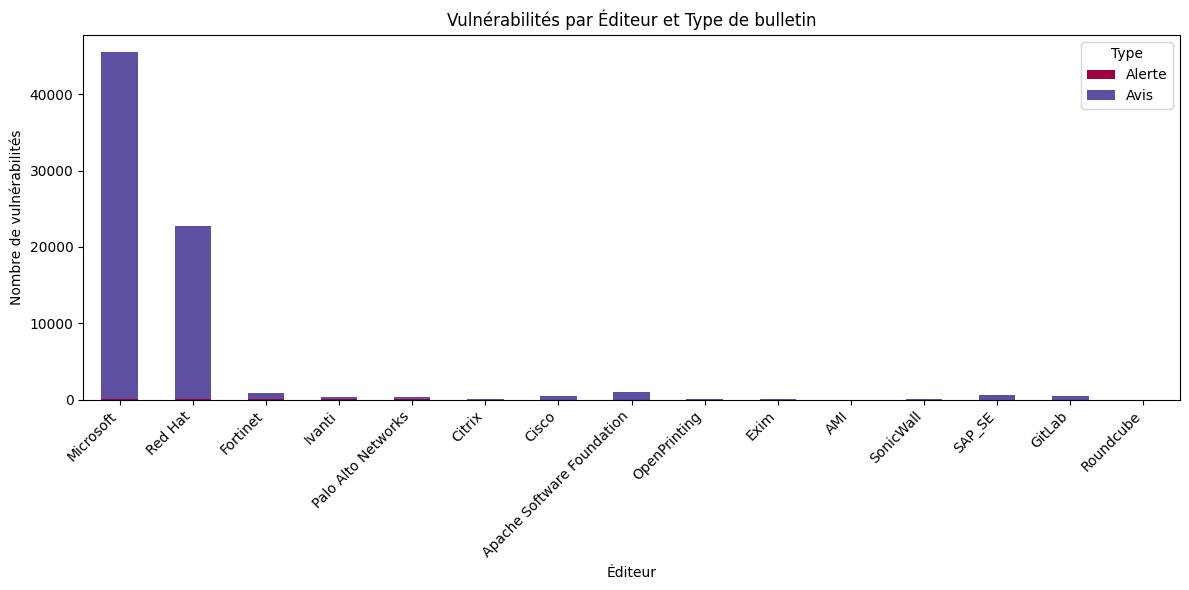

In [74]:

df_bar.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Spectral')
plt.title("Vulnérabilités par Éditeur et Type de bulletin")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 19. Boxplot - Gravité (CVSS) par type de bulletin

Plot

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/3635914293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")


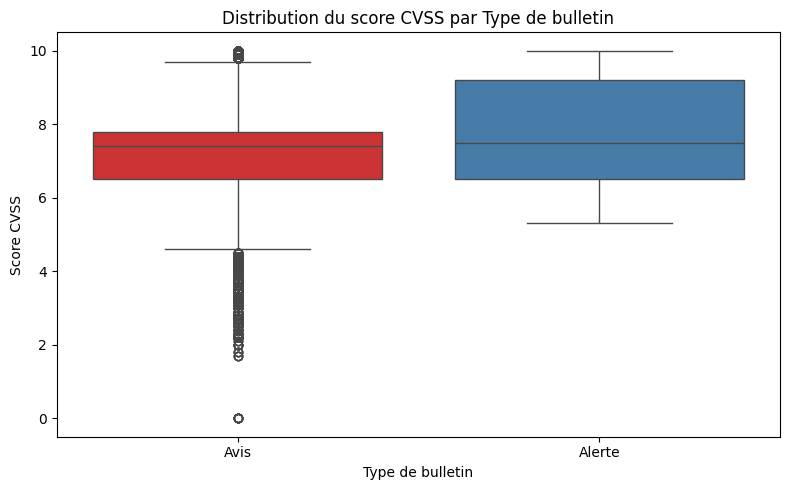

In [75]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")
plt.title("Distribution du score CVSS par Type de bulletin")
plt.xlabel("Type de bulletin")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()

## 20. Heatmap : nombre de vulnerabilités

Garder les 15 editeurs les plus fréquents

In [76]:
top_editeurs = df['Éditeur'].value_counts().head(15).index
df_top = df[df['Éditeur'].isin(top_editeurs)]

Heatmap

In [77]:
heat_data = df_top.groupby(['Éditeur', 'Base Severity']).size().unstack(fill_value=0)
severity_order = ['Critique', 'Élevée', 'Moyenne', 'Faible', 'Non spécifié']
heat_data = heat_data[[s for s in severity_order if s in heat_data.columns]]

Plot

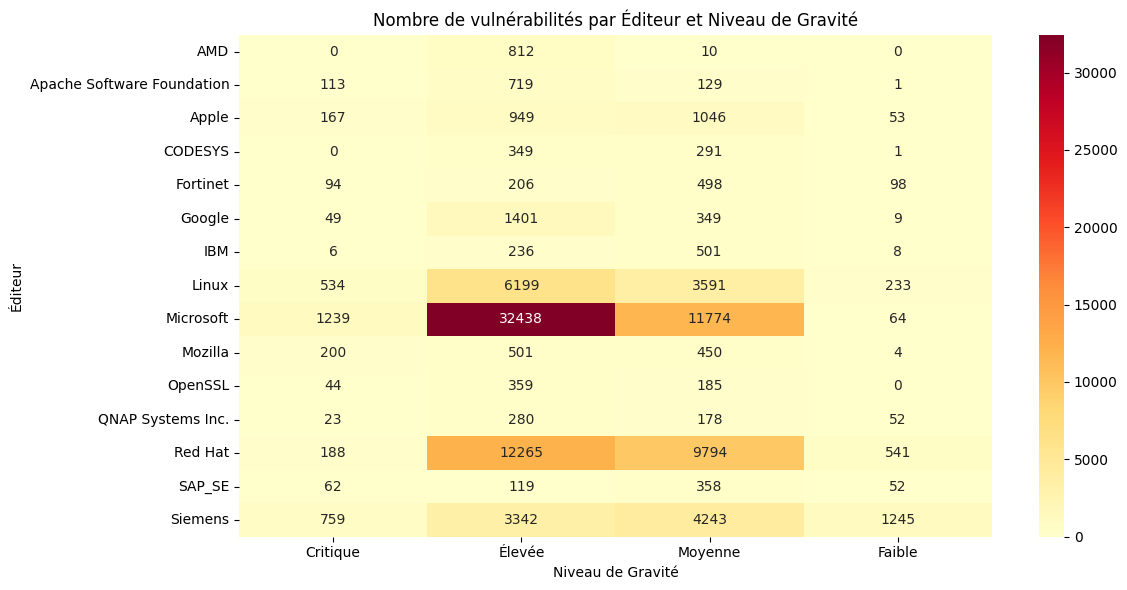

In [78]:
plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Nombre de vulnérabilités par Éditeur et Niveau de Gravité")
plt.xlabel("Niveau de Gravité")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()

## 21. Boxplot : Longueur de la description selon l'éditeur

In [79]:
top_editeurs = df["Éditeur"].value_counts().head(20).index
df_top_editeurs = df[df["Éditeur"].isin(top_editeurs)]

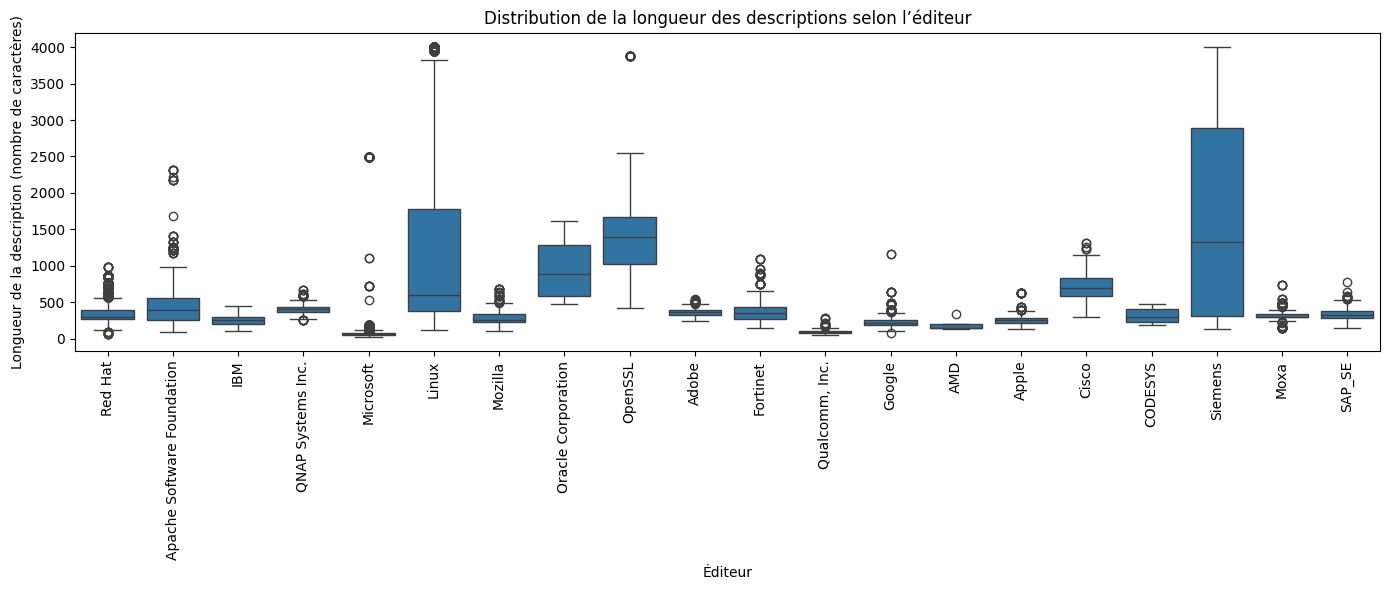

In [80]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top_editeurs, x="Éditeur", y="Longueur description")
plt.xticks(rotation=90)
plt.title("Distribution de la longueur des descriptions selon l’éditeur")
plt.xlabel("Éditeur")
plt.ylabel("Longueur de la description (nombre de caractères)")
plt.tight_layout()
plt.show()


## 22. Boxplot : Remote exploitable vs score EPSS

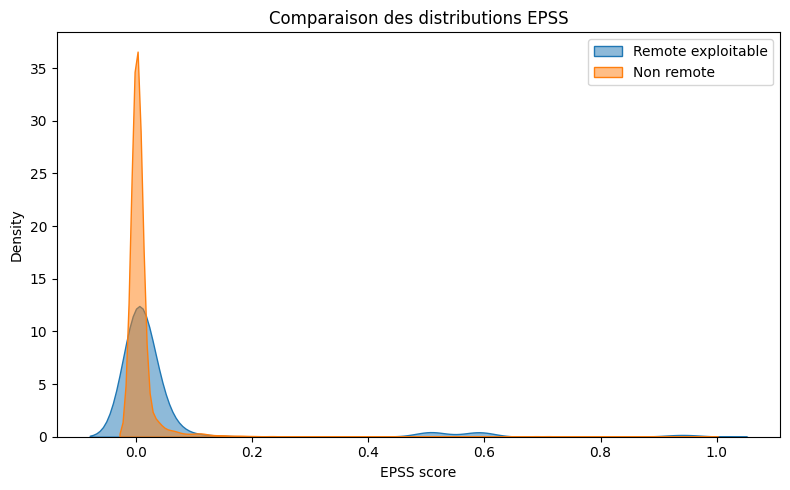

In [81]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df["Remote exploitable"] == True]["EPSS"], label="Remote exploitable", fill=True, alpha=0.5)
sns.kdeplot(df[df["Remote exploitable"] == False]["EPSS"], label="Non remote", fill=True, alpha=0.5)
plt.title("Comparaison des distributions EPSS")
plt.xlabel("EPSS score")
plt.legend()
plt.tight_layout()
plt.show()

## 23. Remote exploitable vs score CVSS

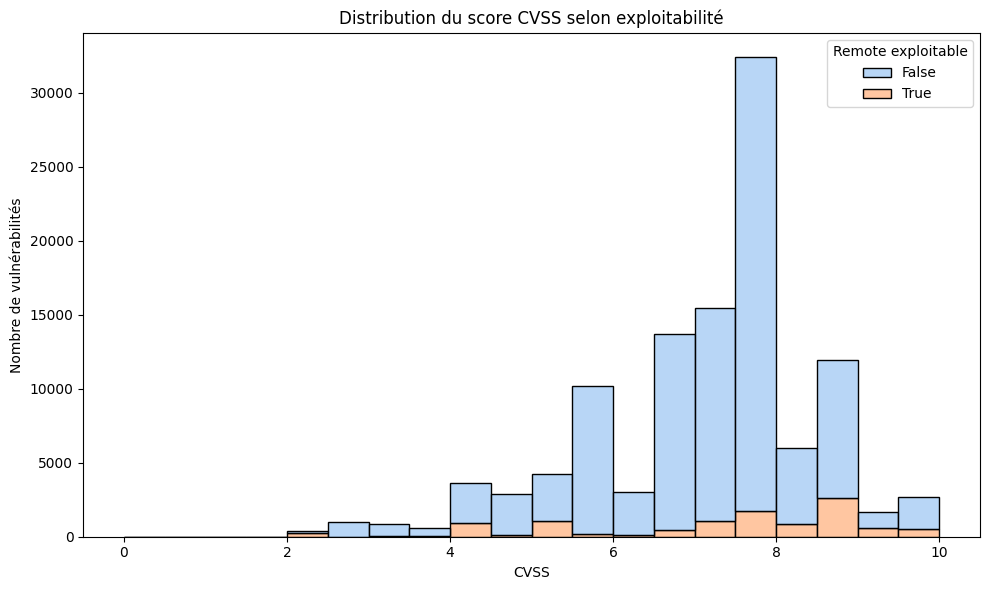

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="CVSS", hue="Remote exploitable", multiple="stack", bins=20, palette="pastel")
plt.title("Distribution du score CVSS selon exploitabilité")
plt.xlabel("CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.tight_layout()
plt.show()


## 24. 3 CWE les plus fréquents pour chaque éditeur

In [83]:
top_editors = df["Éditeur"].value_counts().head(6).index
df_filtered = df[df["Éditeur"].isin(top_editors)]

Obtenir les 3 CWE les plus fréquents pour chaque éditeur

In [84]:
top_cwes_per_editor = (
    df_filtered.groupby(["Éditeur", "CWE"])
    .size()
    .reset_index(name="count")
    .sort_values(["Éditeur", "count"], ascending=[True, False])
    .groupby("Éditeur")
    .head(3)
)

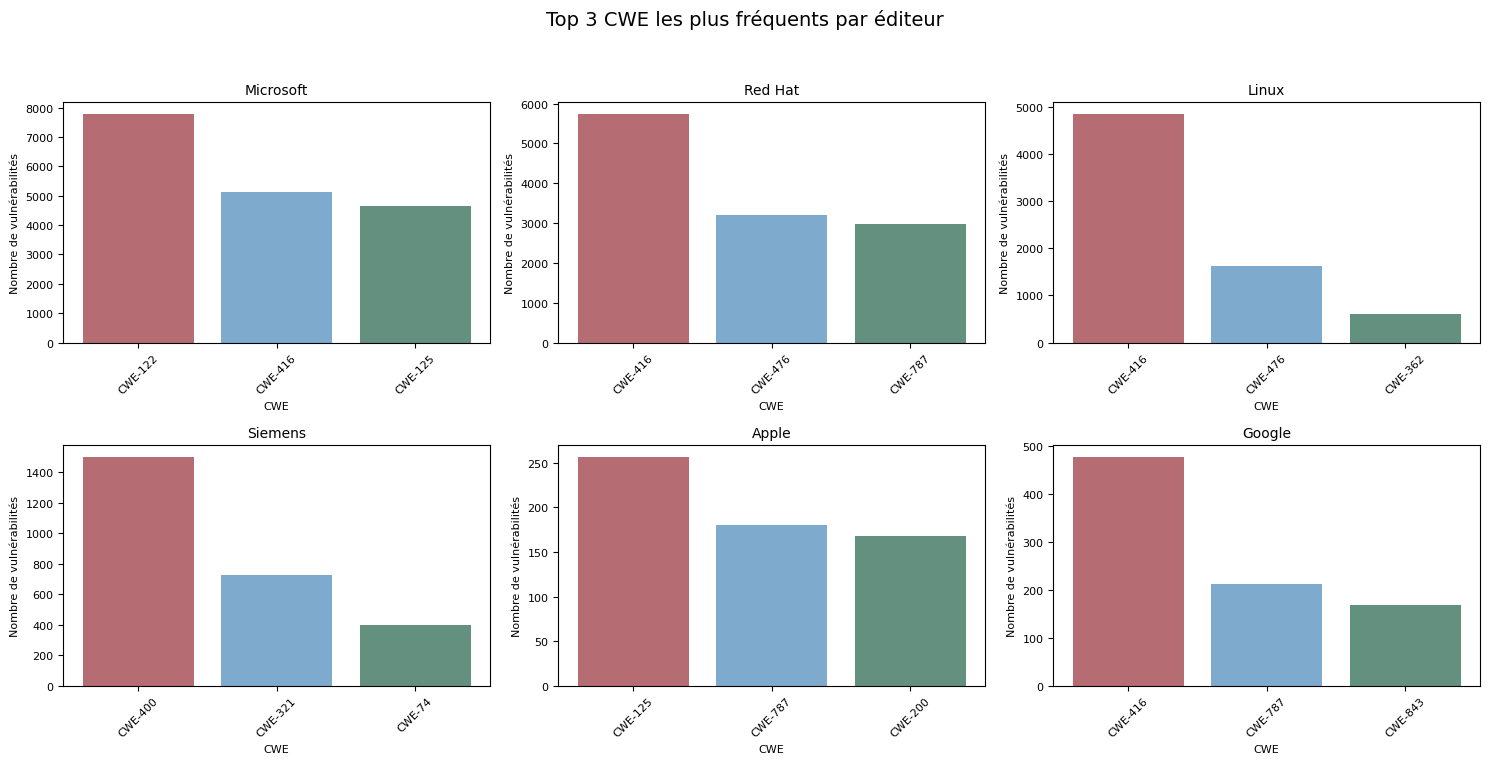

In [85]:
n_editors = len(top_editors)
n_cols = 3
n_rows = (n_editors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

colors = ["#B56C73", "#7DAACD", "#649080"]  # Couleurs pastel

for i, editor in enumerate(top_editors):
    ax = axes[i]
    data = top_cwes_per_editor[top_cwes_per_editor["Éditeur"] == editor]
    ax.bar(data["CWE"], data["count"], color=colors[:len(data)])
    ax.set_title(editor, fontsize=10)
    ax.set_xlabel("CWE", fontsize=8)
    ax.set_ylabel("Nombre de vulnérabilités", fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Supprimer les axes vides si le nombre d’éditeurs < n_rows * n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Top 3 CWE les plus fréquents par éditeur", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Modèles non-supervisés**

## Prédire les CVSS - PCA - KMEANS

### Preprocessing

In [86]:
# data
df1 = df.copy()

#preprocessing:
df1.drop_duplicates(inplace=True)
df1 = df1[(df1['CVSS'] != 'Non disponible') & (df1['CWE'] != 'Non disponible')]

df1.drop(inplace=True, columns=['Versions affectées','Produit','Lien', 'Base Severity', 'CVE', 'Description', 'ID_ANSSI', 'Titre'])

df1.dropna(inplace=True)
print("Nombre de ligne utilisée", max(df1.count(axis=0)))
df1 = df1[['CVSS', 'EPSS', 'CWE', 'Éditeur']]
df1['CVSS'] = pd.to_numeric(df1['CVSS'], errors='coerce')
df1 = pd.get_dummies(df1, columns=['Éditeur', 'CWE'])

df1 = df1.astype(float)

# affectation des variables
X = df1.drop('CVSS', axis = 1)
Y = df1['CVSS'] #Valeur cible

# Centrée-réduite
X_scaled = StandardScaler().fit_transform(X)

Nombre de ligne utilisée 110770


### ACP

In [87]:
pca = PCA(n_components=None)
pca_result = pca.fit_transform(X_scaled)

#### Nombres de Composantes principales

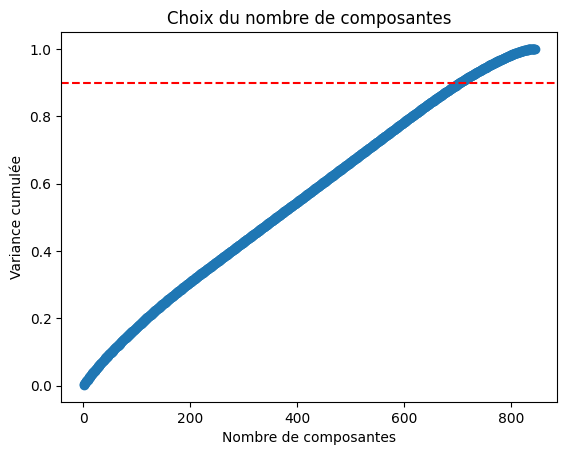

In [ ]:
# Choix du nombre d'axes
explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()

plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.75, color='r', linestyle='--')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Choix du nombre de composantes')
plt.show()

On voit que le nombre d'axes qu'on devrait garder pour avoir une bonne représentativité est 550. Par souci de performances de l'ACP, on prendra 12.

In [89]:
# Correlation variables/axes
correlations = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                            index=X.columns,
                            columns=[f'PC{i+1}' for i in range(len(X.columns))])

# Contributions :
contribs = correlations.abs()
contribs = contribs.div(contribs.sum(axis=0), axis=1)

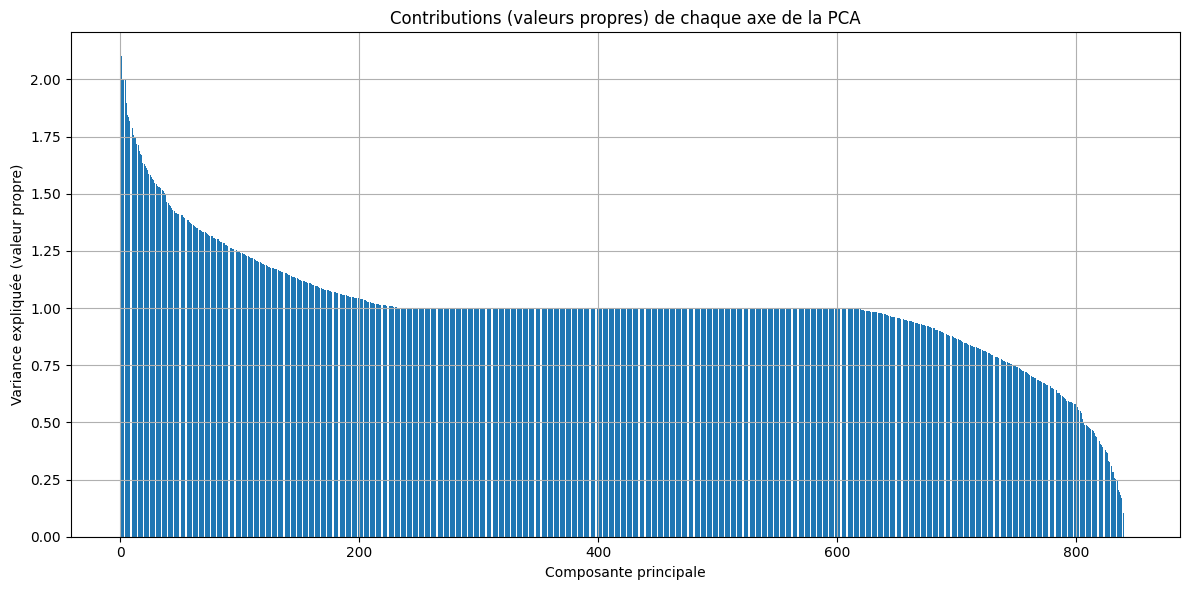

In [90]:

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (valeur propre)")
plt.title("Contributions (valeurs propres) de chaque axe de la PCA")
plt.grid(True)

plt.tight_layout()
plt.show()

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_86294/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

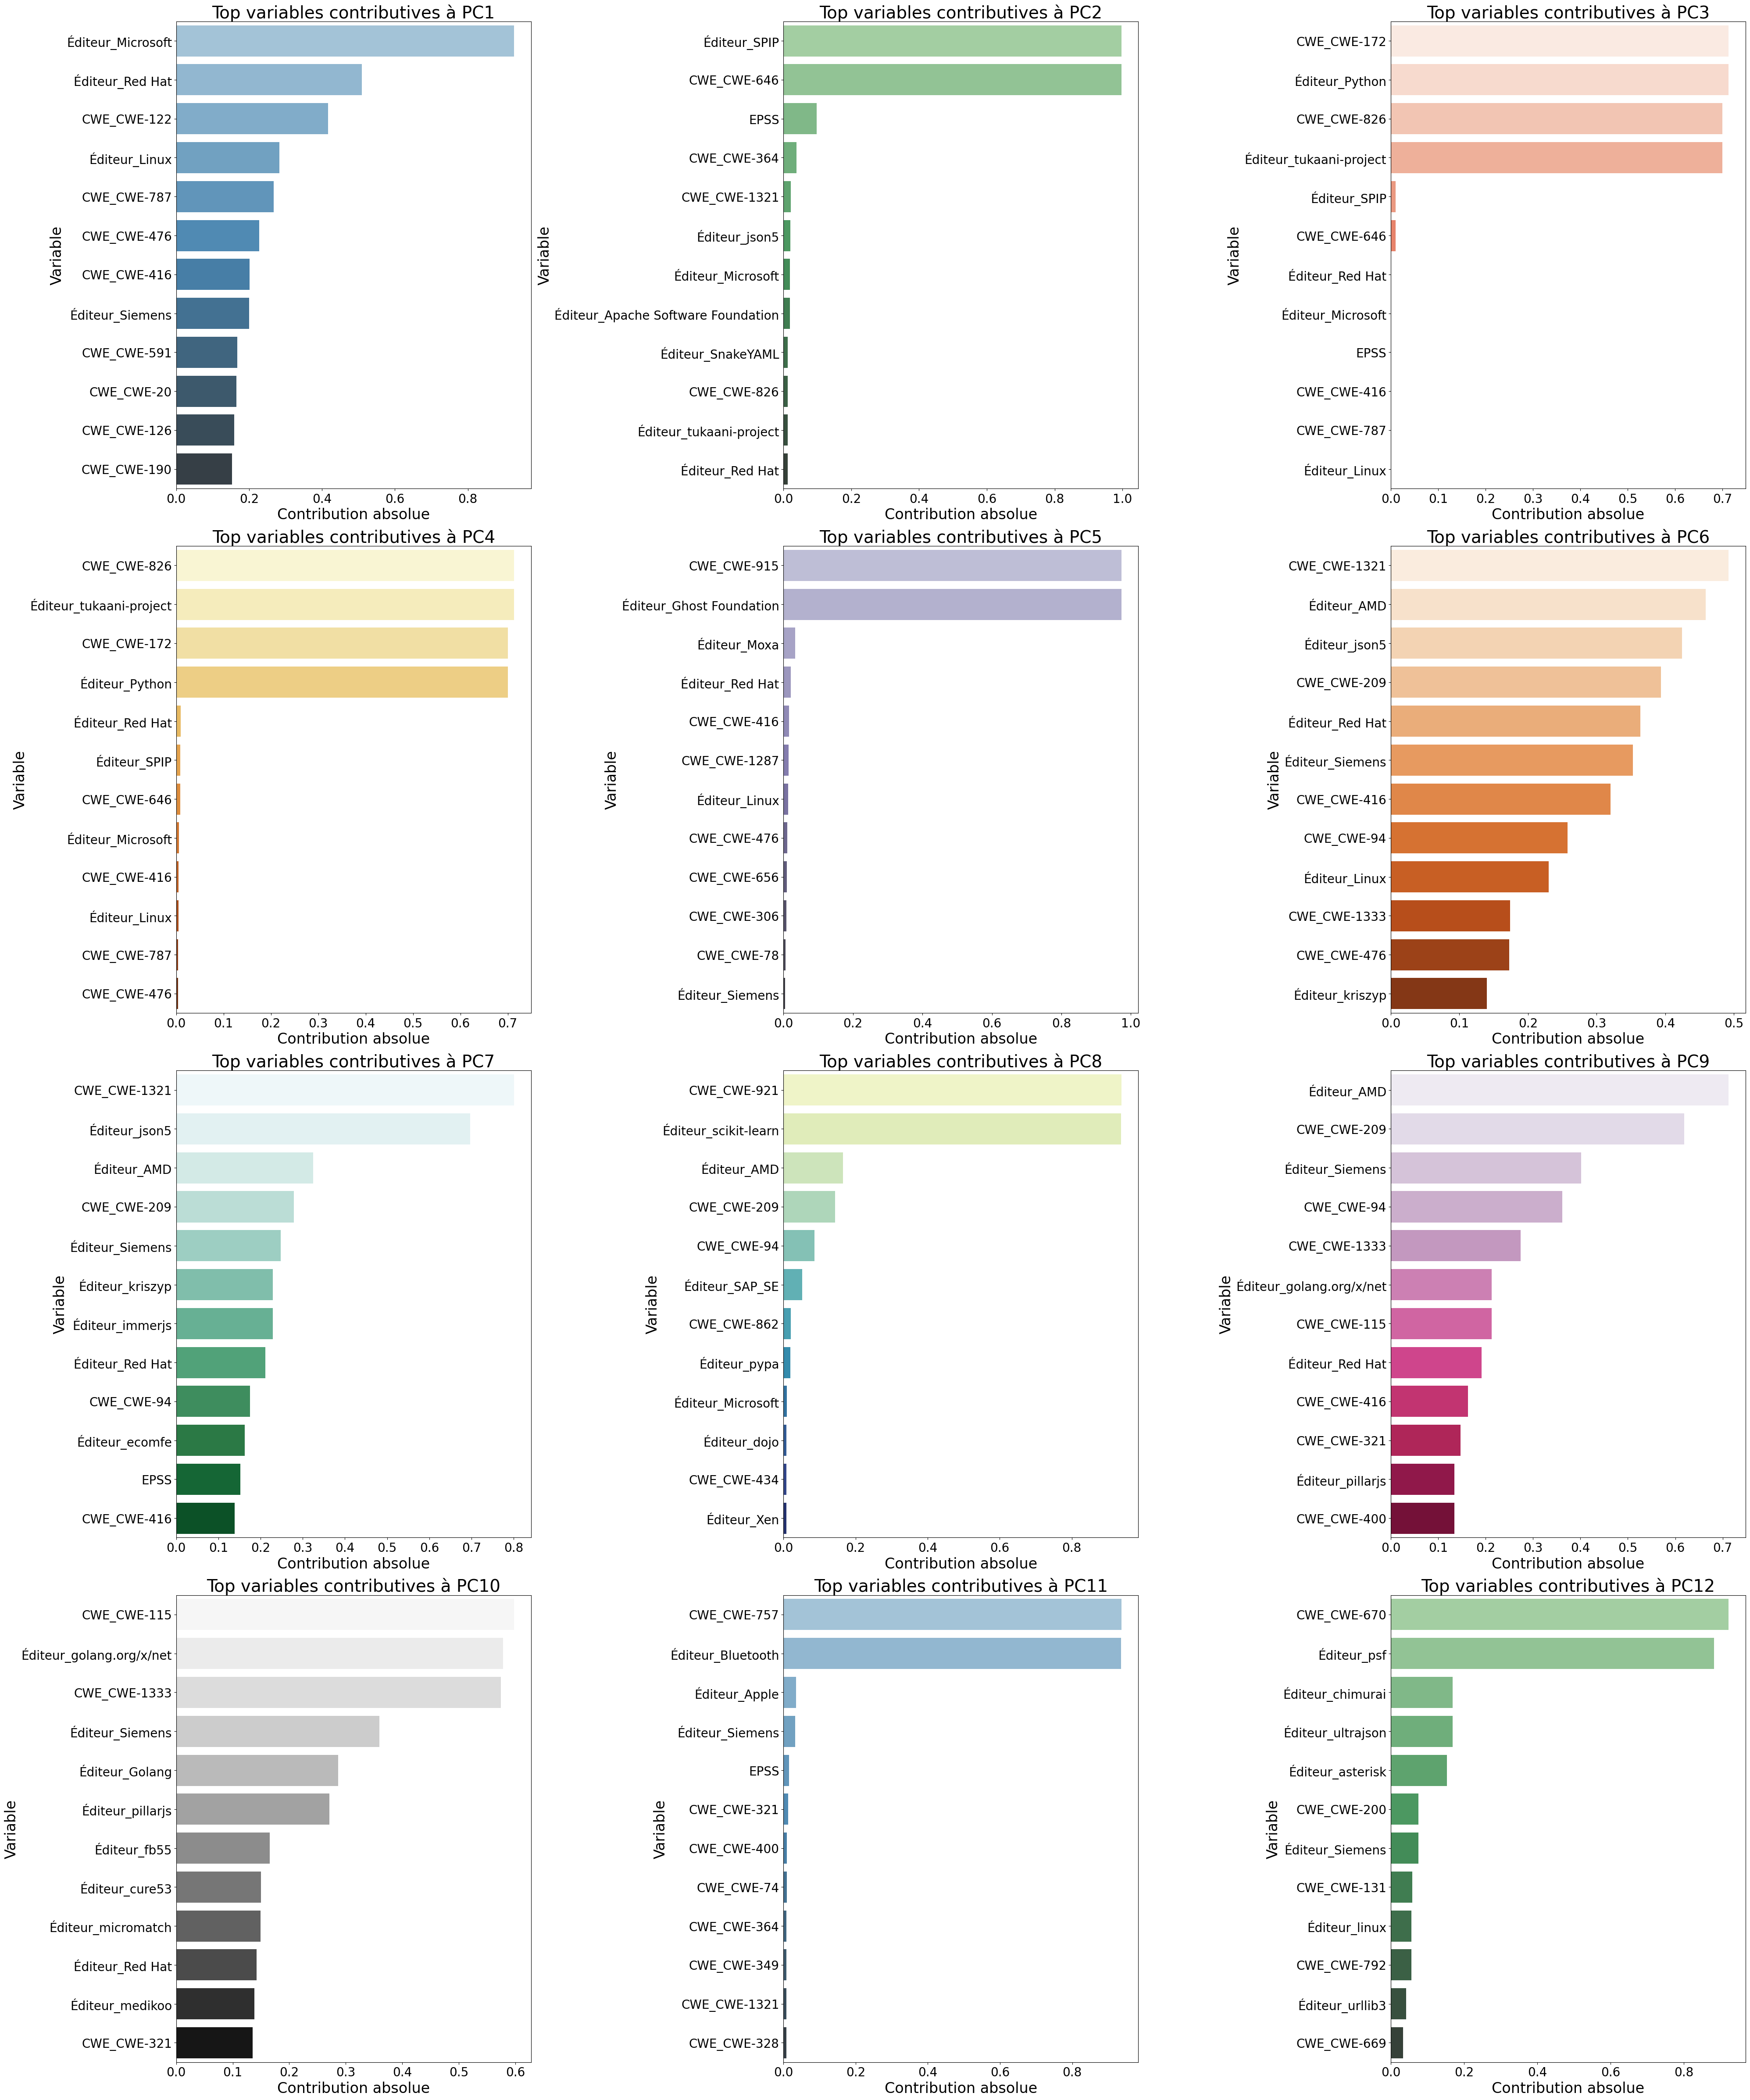

In [91]:
contribs_pc1_pc10 = correlations[[f'PC{i+1}' for i in range(12)]].abs()
top_n = 12

# Récupérer les top variables pour chaque axe
top_pcs = [contribs_pc1_pc10[f'PC{i+1}'].sort_values(ascending=False).head(top_n) for i in range(12)]

fig, axes = plt.subplots(4, 3, figsize=(40, 48))

palettes = ["Blues_d", "Greens_d", "Reds", "YlOrBr", "Purples_d", "Oranges", "BuGn", "YlGnBu", "PuRd", "Greys", "Blues_d", "Greens_d"]

for i in range(12):
    row, col = divmod(i, 3)
    sns.barplot(
        y=top_pcs[i].index,
        x=top_pcs[i].values,
        palette=palettes[i],
        ax=axes[row, col]
    )
    axes[row, col].set_title(f"Top variables contributives à PC{i+1}", fontsize=28)
    axes[row, col].set_xlabel("Contribution absolue", fontsize=24)
    axes[row, col].set_ylabel("Variable", fontsize=24)
    axes[row, col].tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.show()


#### Exemple d'un cercle de corrélaation

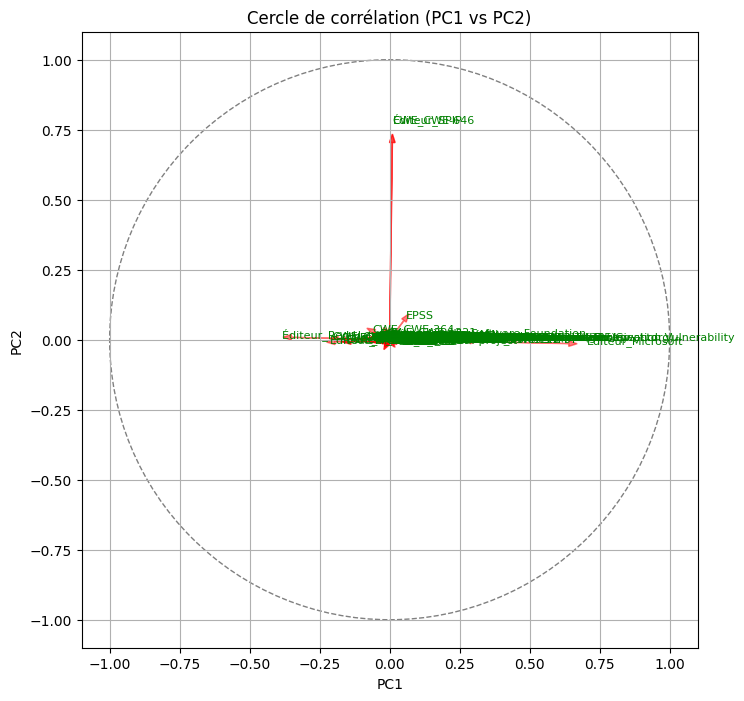

In [92]:
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Afficher les flèches pour chaque variable
for i in range(len(X.columns)):
    plt.arrow(0, 0, 
              pca.components_[0, i], 
              pca.components_[1, i], 
              color='r', alpha=0.5, head_width=0.02)
    plt.text(pca.components_[0, i]*1.1, 
             pca.components_[1, i]*1.1, 
             X.columns[i], color='g', fontsize=8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cercle de corrélation (PC1 vs PC2)")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### KMeans

#### Choix du nombre de clusters

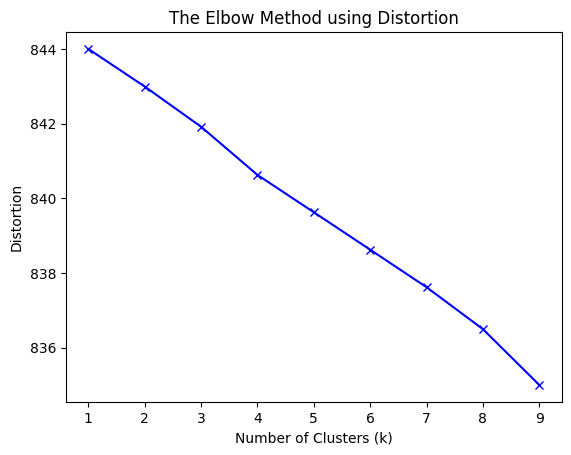

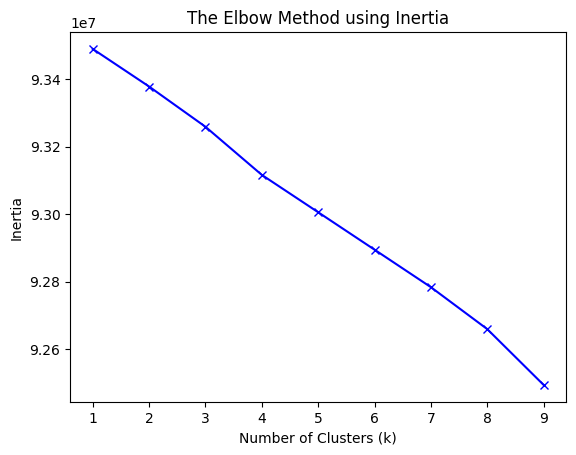

In [93]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

#distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

#inertie
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

On considérera que le nombre de clusters optimal est 3.

### KMeans x ACP

In [147]:
n = 12
pca = PCA(n_components=n)
pca_result = pca.fit_transform(X_scaled)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(pca_result)

#### Visualisation

Par souci de visualisation, on choisira de représenter les variables uniquement sur les axes PC1 et PC2

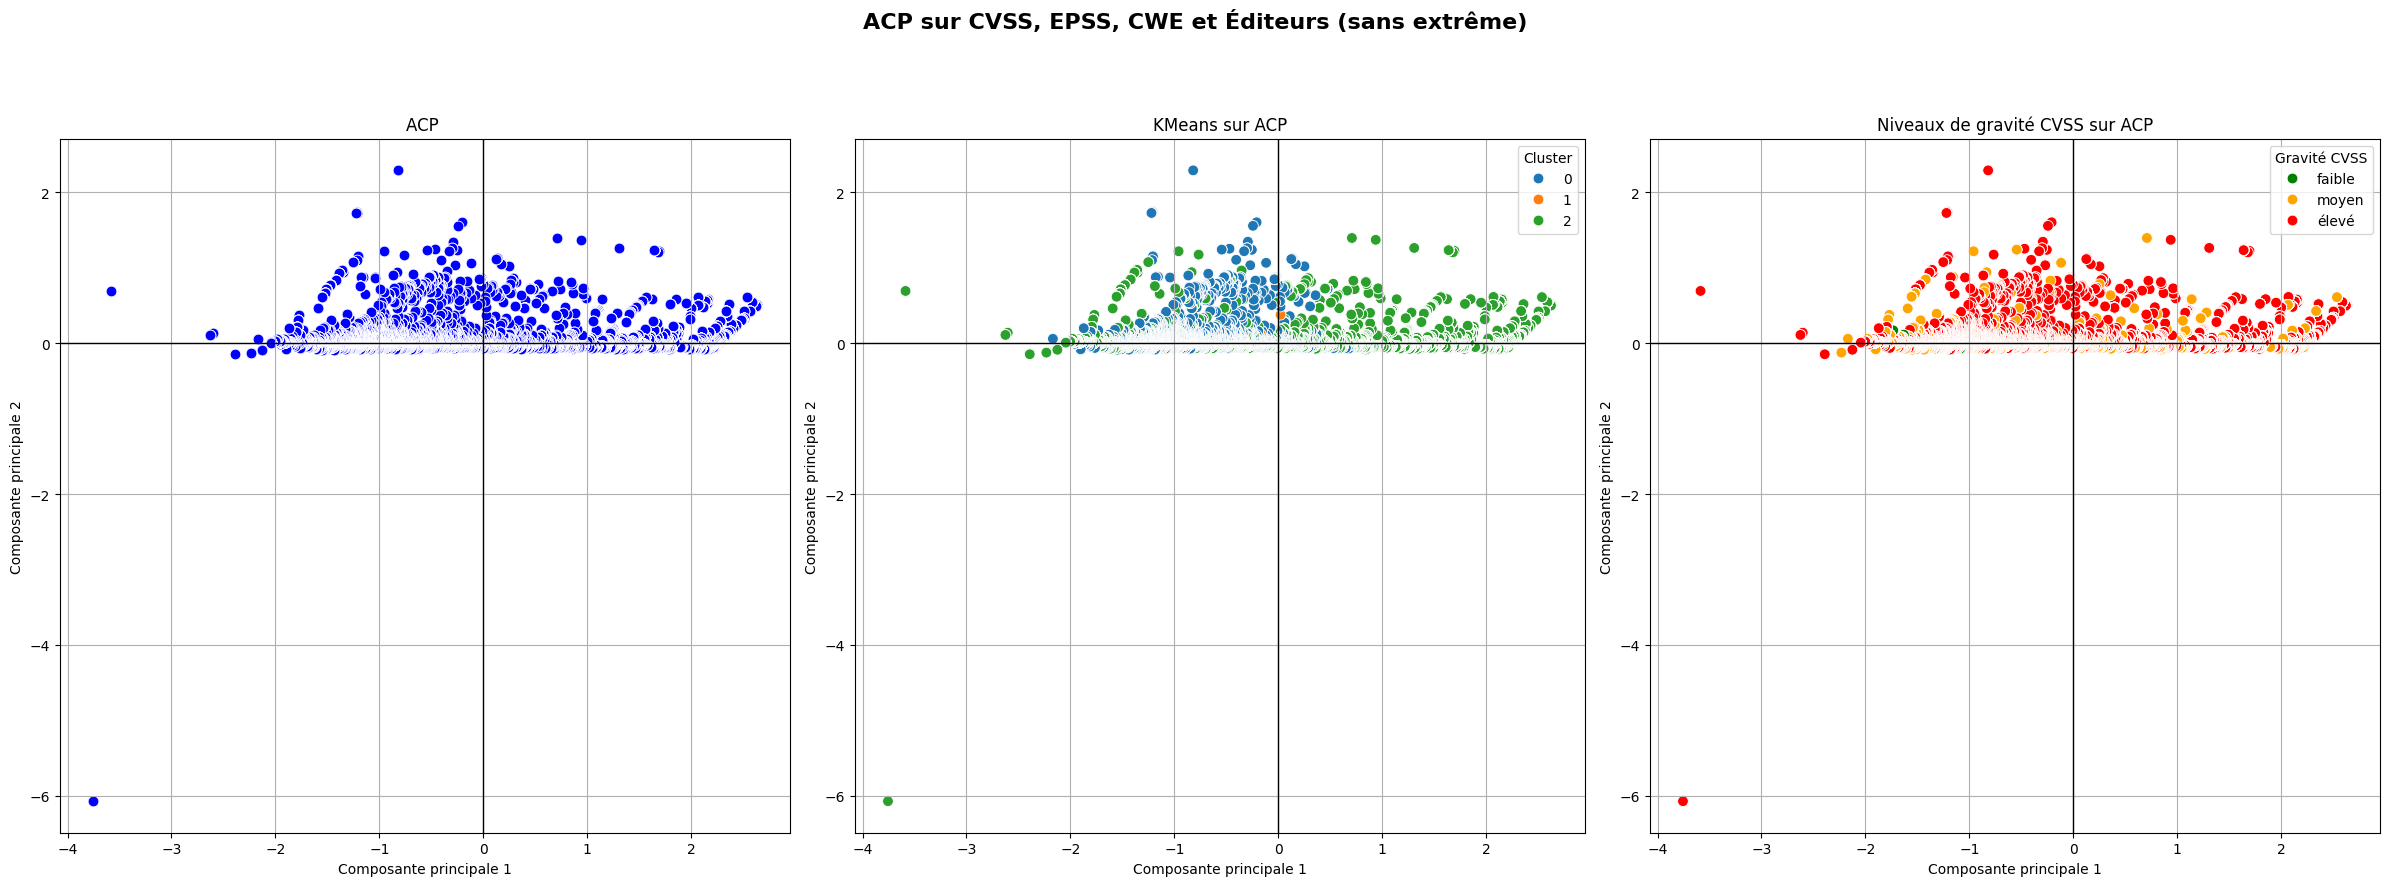

In [152]:
pca_df = pd.DataFrame(pca_result[:, :2], columns=["PC1", "PC2"])
pca_df_trimmed = pca_df.sort_values(by="PC1", ascending=False).iloc[3:]

pca_df_full = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(n)])
pca_df_full["PC1"] = pca_result[:, 0]
pca_df_full["PC2"] = pca_result[:, 1]
pca_df_full["cluster"] = cluster_labels
pca_df_full_trimmed = pca_df_full.sort_values(by="PC1", ascending=False).iloc[3:]

df1['PC1'] = pca_result[:, 0]
df1['PC2'] = pca_result[:, 1]
df1['cluster'] = cluster_labels
df1['cvss_niveau'] = pd.cut(
    df1['CVSS'],
    bins=[0, 4, 7, 10],
    labels=['faible', 'moyen', 'élevé'],
    include_lowest=True
)
pca_df_visu = df1.sort_values(by="PC1", ascending=False).iloc[3:]

# 4. Affichage des 3 plots côte à côte
fig, axes = plt.subplots(1, 3, figsize=(24, 9))
fig.suptitle("ACP sur CVSS, EPSS, CWE et Éditeurs (sans extrême)", fontsize=16, fontweight='bold')

# Subplot 1 : PCA simple
sns.scatterplot(ax=axes[0], x="PC1", y="PC2", data=pca_df_trimmed, s=60, color='blue')
axes[0].set_title("ACP ")
axes[0].axhline(0, color='black', linewidth=1)
axes[0].axvline(0, color='black', linewidth=1)
axes[0].set_xlabel("Composante principale 1")
axes[0].set_ylabel("Composante principale 2")
axes[0].grid(True)

# Subplot 2 : PCA + KMeans
sns.scatterplot(
    ax=axes[1], x="PC1", y="PC2",
    hue="cluster", data=pca_df_full_trimmed,
    palette="tab10", s=60
)
axes[1].set_title("KMeans sur ACP")
axes[1].axhline(0, color='black', linewidth=1)
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_xlabel("Composante principale 1")
axes[1].set_ylabel("Composante principale 2")
axes[1].grid(True)
axes[1].legend(title="Cluster")

# Subplot 3 : PCA + CVSS niveau
sns.scatterplot(
    ax=axes[2], x="PC1", y="PC2",
    hue="cvss_niveau", data=pca_df_visu,
    palette={'faible': 'green', 'moyen': 'orange', 'élevé': 'red'}, s=60
)
axes[2].set_title("Niveaux de gravité CVSS sur ACP")
axes[2].axhline(0, color='black', linewidth=1)
axes[2].axvline(0, color='black', linewidth=1)
axes[2].set_xlabel("Composante principale 1")
axes[2].set_ylabel("Composante principale 2")
axes[2].grid(True)
axes[2].legend(title="Gravité CVSS")

plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


In [145]:
df1['cluster'] = cluster_labels
df1.groupby('cluster')['CVSS'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,23126.0,6.438117,1.729833,0.0,5.3,6.8,7.5,10.0
1,954.0,7.237631,0.651481,3.1,7.3,7.3,7.5,9.8
2,86690.0,7.221275,1.253186,2.0,6.5,7.5,7.8,10.0


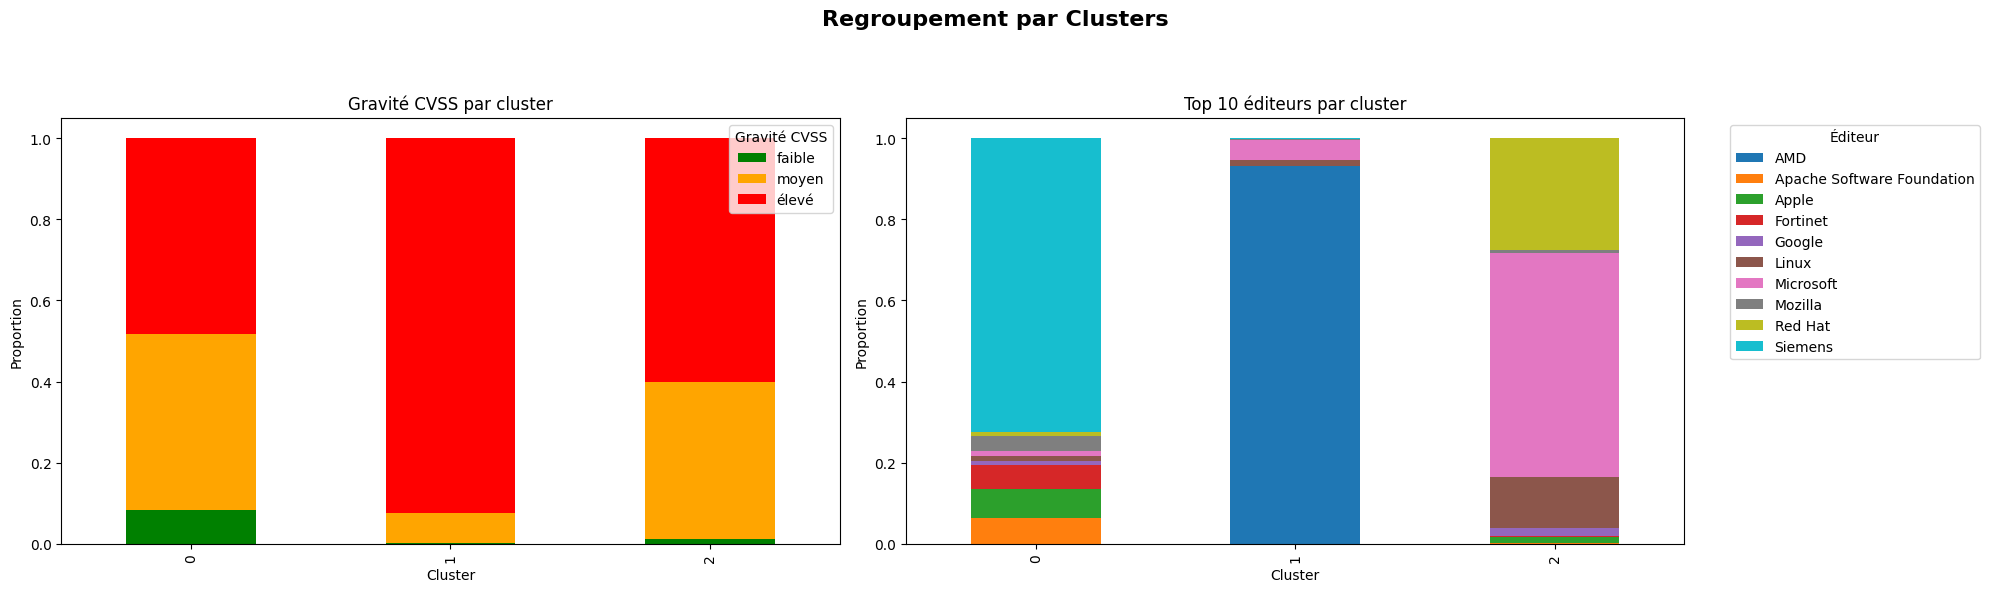

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

editeur_cols = [col for col in df1.columns if col.startswith('Éditeur_')]
df1['Éditeur'] = df1[editeur_cols].idxmax(axis=1).str.replace('Éditeur_', '', regex=False)


df1['cvss_niveau'] = pd.cut(
    df1['CVSS'],
    bins=[0, 4, 7, 10],
    labels=['faible', 'moyen', 'élevé'],
    include_lowest=True
)


cross_tab_cvss = pd.crosstab(df1['cluster'], df1['cvss_niveau'])
proportions_cvss = cross_tab_cvss.div(cross_tab_cvss.sum(axis=1), axis=0)

top10_editeurs = df1['Éditeur'].value_counts().head(10).index
df_top_editeurs = df1[df1['Éditeur'].isin(top10_editeurs)]

cross_tab_editeurs = pd.crosstab(df_top_editeurs['cluster'], df_top_editeurs['Éditeur'])
proportions_editeurs = cross_tab_editeurs.div(cross_tab_editeurs.sum(axis=1), axis=0)


fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Regroupement par Clusters", fontsize=16, fontweight='bold')

# Plot 1 : CVSS
proportions_cvss.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    color=['green', 'orange', 'red']
)
axes[0].set_title('Gravité CVSS par cluster')
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Proportion")
axes[0].legend(title="Gravité CVSS", loc='upper right')

# Plot 2 : Éditeurs
proportions_editeurs.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    colormap='tab10'
)
axes[1].set_title('Top 10 éditeurs par cluster')
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Proportion")
axes[1].legend(title="Éditeur", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


On voit bien que le clustering fonctionne efficacement sur les variables utilisées lors de l’entraînement. L’exemple ci-dessus illustre que le regroupement par éditeur est bien capté par l’algorithme. En revanche, les clusters ne correspondent pas aux niveaux de gravité CVSS, ce qui est cohérent puisque ces derniers n’étaient pas pris en compte dans la réduction de dimension (PCA) ni dans l’algorithme de clustering (KMeans).

## Prédire les Eiteurs - KMeans

In [155]:

np.random.seed(42)
n_samples = 500
df2 = df.copy()
df2 = df2[['CVSS', 'Éditeur', 'EPSS']]
df2.dropna(inplace=True)

In [157]:
top_editors = df2['Éditeur'].value_counts().head(10).index
data_top = df2[df2['Éditeur'].isin(top_editors)].copy()
le_editor = LabelEncoder()
data_top['editor_encoded'] = le_editor.fit_transform(data_top['Éditeur'])


In [158]:
X = data_top[['CVSS', 'EPSS']]
Y = data_top['editor_encoded']

### KMeans

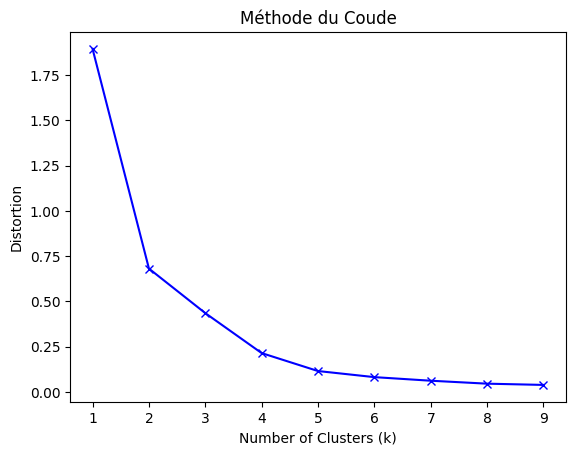

In [159]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])    
    mapping1[k] = distortions[-1]

#distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Méthode du Coude')
plt.show()

Le nombre optimal de cluster est 2

In [160]:
kmeans = KMeans(n_clusters=2, random_state=42)
data_top['cluster'] = kmeans.fit_predict(X)

### Visualisation

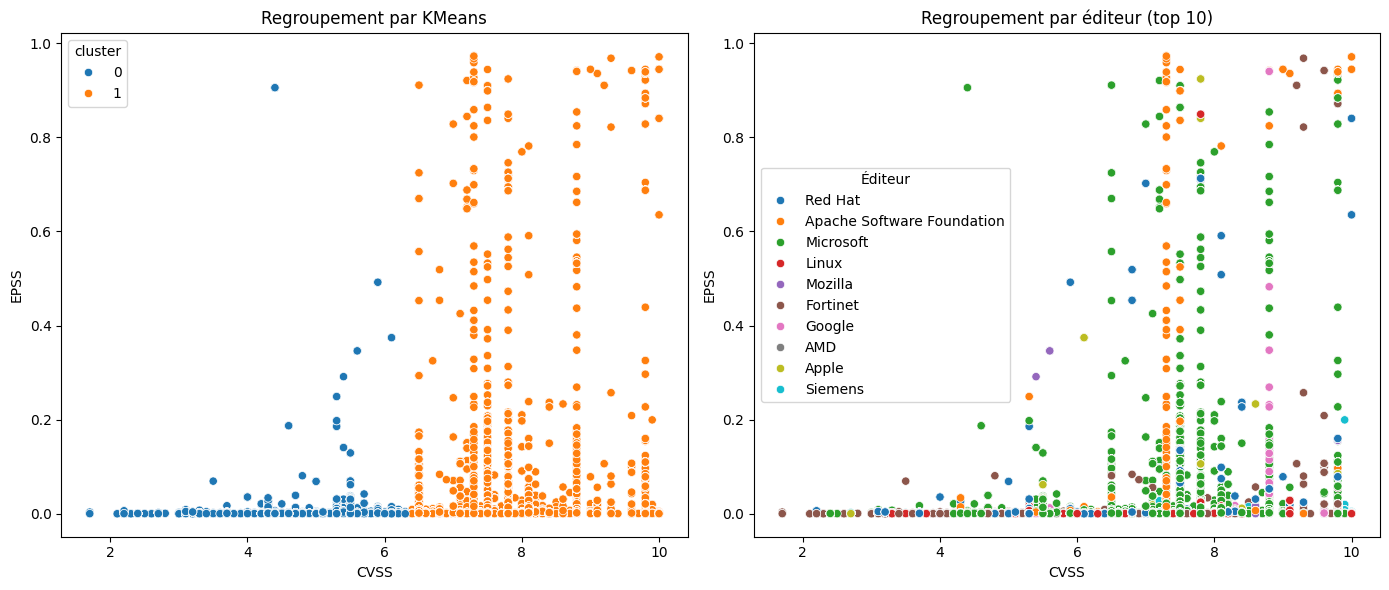

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(ax=axes[0], x='CVSS', y='EPSS', hue='cluster', data=data_top, palette='tab10')
axes[0].set_title('Regroupement par KMeans')
sns.scatterplot(ax=axes[1], x='CVSS', y='EPSS', hue='Éditeur', data=data_top, palette='tab10')
axes[1].set_title('Regroupement par éditeur (top 10)')
plt.tight_layout()
plt.show()


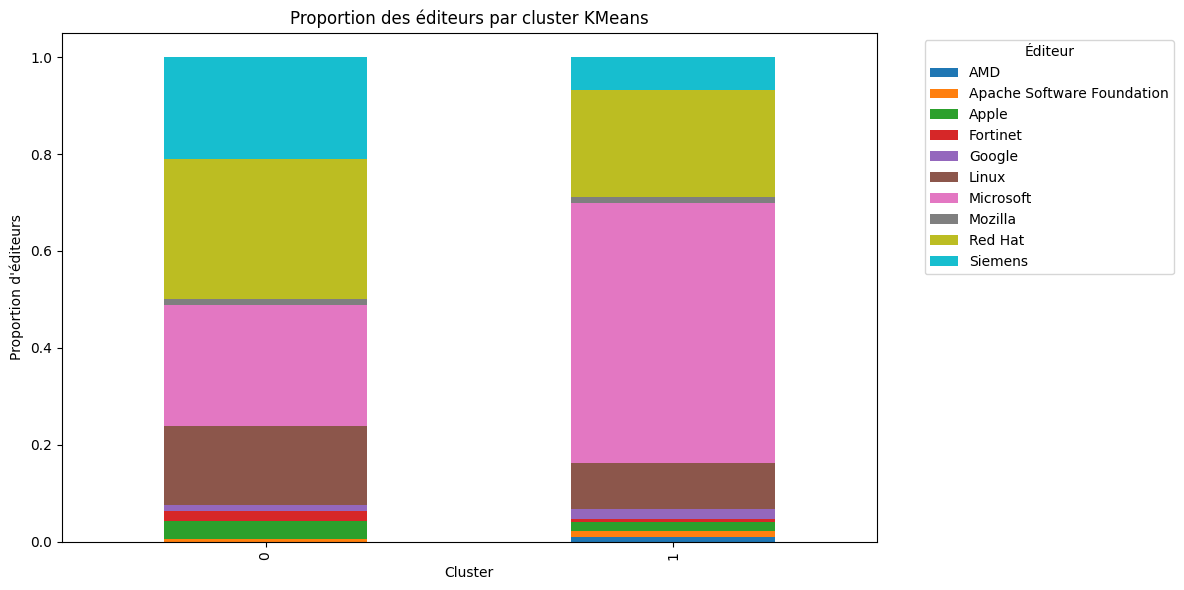

In [162]:
# BarPlot
cross_tab_inverse = pd.crosstab(data_top['cluster'], data_top['Éditeur'])
proportions_inverse = cross_tab_inverse.div(cross_tab_inverse.sum(axis=1), axis=0)

proportions_inverse.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title('Proportion des éditeurs par cluster KMeans')
plt.xlabel("Cluster")
plt.ylabel("Proportion d'éditeurs")
plt.legend(title='Éditeur', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **Modèles supervisés**

## Random Forest pour prédire Base Severity

Labellisation

In [101]:
features = ['Type', 'CWE', 'EPSS', 'Remote exploitable', 'Longueur description']
target = 'Base Severity'

le_type = LabelEncoder()
le_cwe = LabelEncoder()
le_target = LabelEncoder()

df_IA['Type'] = le_type.fit_transform(df_IA['Type'])
df_IA['CWE'] = le_cwe.fit_transform(df_IA['CWE'])
df_IA[target] = le_target.fit_transform(df_IA[target])

In [102]:
X = df_IA[features]
y = df_IA[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Évaluation

In [103]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy : 0.9645210797147242
Classification report:
              precision    recall  f1-score   support

    Critique       0.96      0.87      0.91      1322
      Faible       0.98      0.86      0.91       801
     Moyenne       0.95      0.96      0.96     11323
      Élevée       0.97      0.98      0.97     19785

    accuracy                           0.96     33231
   macro avg       0.97      0.92      0.94     33231
weighted avg       0.96      0.96      0.96     33231

Confusion matrix:
[[ 1152     1    43   126]
 [    2   687    70    42]
 [   12     8 10879   424]
 [   31     6   414 19334]]


Visualisation

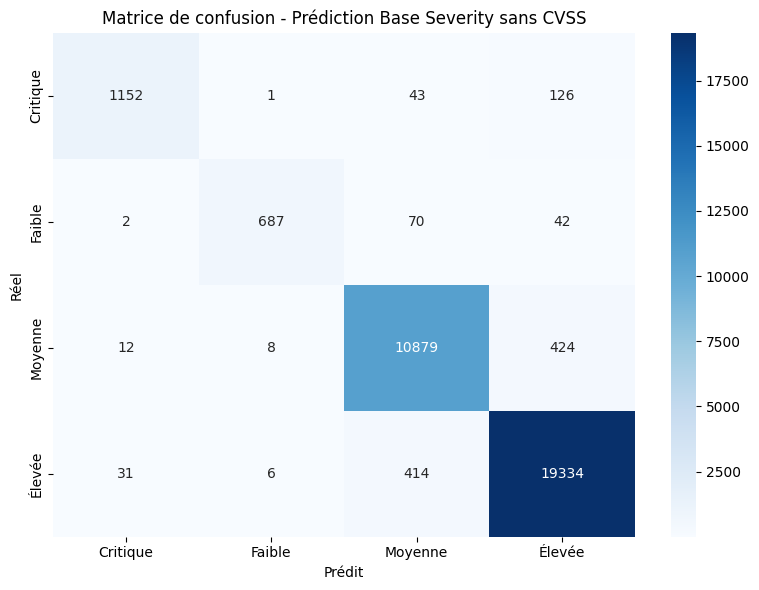

In [104]:
cm = confusion_matrix(y_test, y_pred)
labels = le_target.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - Prédiction Base Severity sans CVSS')
plt.tight_layout()
plt.show()

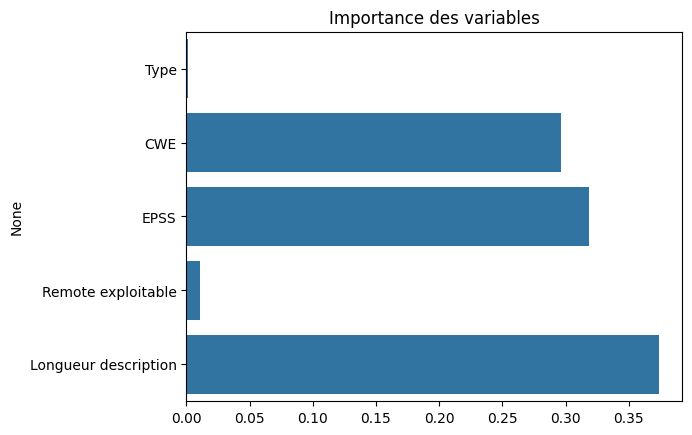

In [105]:
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Importance des variables")
plt.show()

Cross Validation

In [106]:
model_cv = RandomForestClassifier(random_state=42)

scores_acc = cross_val_score(model_cv, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Accuracy : 0.8159880834160873


## Random Forest pour prédire EPSS

Data preparing

In [107]:
df_reg = df_IA.copy()
df_reg = df_reg[df_reg['EPSS'].notna()]
df_reg = df_reg[df_reg['EPSS'] != '']
df_reg['EPSS'] = df_reg['EPSS'].astype(float)

features = ['CWE','Type','Éditeur','Produit','Remote exploitable','Longueur description']

Labellisation

In [108]:
df_encoded = df_reg[features].copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

Modèle Random Forest

In [109]:
X = df_encoded
y = df_reg['EPSS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [110]:
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

print("R²  :", r2_score(y_test, y_pred))

MAE : 0.017493262001680696
MSE : 0.005424712299995549
RMSE: 0.07365264625249761
R²  : 0.44289932594495107


Cross Validation

In [111]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
scores_rmse = (-cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error'))
scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("MAE  : ", scores_mae.mean())
print("RMSE : ", scores_rmse.mean())
print("R²   : ", scores_r2.mean())

MAE  :  0.01742250797622489
RMSE :  0.07400955564173013
R²   :  0.4813142133869011


Visualisation

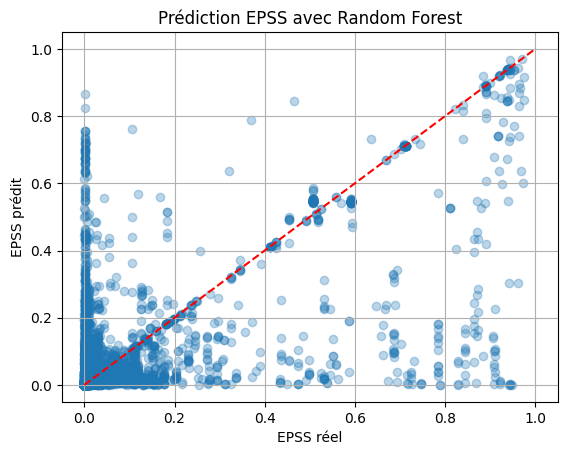

In [112]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("EPSS réel")
plt.ylabel("EPSS prédit")
plt.title("Prédiction EPSS avec Random Forest")
plt.plot([0, 1], [0, 1], 'r--')
plt.grid()
plt.show()

## XGBoost Regressor pour prédire EPSS

In [113]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R²  :", r2_score(y_test, y_pred))

NameError: name 'XGBRegressor' is not defined

Cross Validation

In [ ]:
scores_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
scores_rmse = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')


print("MAE  : ", scores_mae.mean())
print("RMSE : ", scores_rmse.mean())
print("R²   : ", scores_r2.mean())

## Random Forest pour prédire l'éditeur

Random Forest sans SMOTE (échantillonage)

In [ ]:
df_clf = df_IA.dropna(subset=["CVSS", "EPSS", "CWE", "Remote exploitable", "Longueur description"])
df_clf = df_clf[df_clf["Éditeur"].map(df_clf["Éditeur"].value_counts()) > 50]  # éditeurs fréquents

le_editeur = LabelEncoder()
df_clf["Éditeur_encoded"] = le_editeur.fit_transform(df_clf["Éditeur"])

le_cwe = LabelEncoder()
df_clf["CWE_encoded"] = le_cwe.fit_transform(df_clf["CWE"].astype(str))

df_clf["Remote Exploitable"] = df_clf["Remote exploitable"].map({"True": 1, "False": 0})
df_clf["Remote Exploitable"].fillna(0, inplace=True)


features = [
    "CVSS",
    "EPSS",
    "CWE_encoded",
    "Remote Exploitable",
    "Longueur description"
]

X = df_clf[features]
y = df_clf["Éditeur_encoded"]


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


Cross Validation

In [ ]:
scores_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Visualisation

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Random Forest avec SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test)


print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Cross Validation

In [ ]:
scores_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Visualisation

In [ ]:
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Importance des variables")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_, 
            annot=False, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_scores = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        f1_scores[label] = report_dict[str(i)]["f1-score"]
    except KeyError:
        f1_scores[label] = 0


f1_scores_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores_sorted.keys()), y=list(f1_scores_sorted.values()))
plt.xticks(rotation=90)
plt.title("F1-score par éditeur")
plt.ylabel("F1-score")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()

In [ ]:
support = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        support[label] = report_dict[str(i)]["support"]
    except KeyError:
        support[label] = 0  


plt.figure(figsize=(12, 6))
sns.barplot(x=list(support.keys()), y=list(support.values()))
plt.xticks(rotation=90)
plt.title("Nombre d’exemples par éditeur dans le test set")
plt.ylabel("Exemples")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()